In [2]:
import json
import random
import datetime
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
# from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# from numba import cuda
# cuda.select_device(0)
# cuda.close()

import LSTMbasictraining as lbt
t
%matplotlib inline


2.1.0


In [3]:
path_dataset = 'AN-NAN-Hypotension-datasets/Prediction_Hypo_IRB_Data_set/'
file1 = 'patient-aggregate-features--format-IV.3-valid.csv'
file2 = 'patient-aggregate-features--format-IV.3--delta-all.csv'
bp_data_file = 'patient_all_data_set/bp_data_1024.csv'

df_train = lbt.readDataset(path_dataset + file2)
# df_train.groupby(['Hypo_90mmHg']).size()
df_train.groupby(['Hypo_delta_20']).size()

# df_train = df_train.iloc[:,np.r_[:30,31:df_train.shape[1]]]
for c in df_train.columns:
    df_train[c] = df_train[c].astype(str)
    
df_train.shape
df_train.head()
df_train.columns



Hypo_delta_20
0.0    10274
1.0     1697
dtype: int64

(11971, 74)

,hmpcrtno,day_stamp,time_stamp,vpressure,apressure,tmp,abf,ttemper,atemper,conductivity,ufrate,uftarget,ufvolume,uftime,flowrate,currflowrate,bloodleakv,cloudingv,cyclicpht,targetsodium,bicarbonatea,effectivebf,accumulatbv,startsodium,ufprofile,sodiumpfile,hpdelrate,watch,daidate,daitime,systole,map,diastolic,pulserate,Hypo_delta_20,Hypo_90mmHg,previous_systole,oCare_HR_mean,oCare_HR_cv,oCare_SpO2_mean,oCare_SpO2_cv,delta_systole,delta_map,delta_diastolic,delta_pulserate,delta_previous_systole,delta_vpressure,delta_apressure,delta_tmp,delta_abf,delta_ttemper,delta_atemper,delta_conductivity,delta_ufrate,delta_uftarget,delta_ufvolume,delta_uftime,delta_flowrate,delta_currflowrate,delta_bloodleakv,delta_cloudingv,delta_cyclicpht,delta_targetsodium,delta_bicarbonatea,delta_effectivebf,delta_accumulatbv,delta_startsodium,delta_ufprofile,delta_sodiumpfile,delta_hpdelrate,delta_oCare_HR_mean,delta_oCare_HR_cv,delta_oCare_SpO2_mean,delta_oCare_SpO2_cv
0,3376.0,0.0,0.0,193.2,-0.4,49.8,249.0,35.5,35.6,13.7,0.4,1.3,0.04,200.8,500.0,521.0,50.8,49.0,150.0,1380.0,0.0,248.4,20.2,0.0,0.0,0.0,10.0,5.0,1090821.0,74159.0,171.0,89.0,55.0,74.0,1.0,0.0,209.0,57.38600235207435,0.04653024003318392,71.64483501496981,0.0183681205992563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3376.0,0.0,1.0,168.0,-0.4,48.4,249.0,35.5,35.66000000000001,13.720000000000002,0.4,1.3,0.1,190.0,500.0,522.6,51.0,48.2,750.0,1380.0,0.0,249.0,46.4,0.0,0.0,0.0,10.0,5.0,1090821.0,75159.0,171.0,89.0,55.0,74.0,1.0,0.0,209.0,57.38600235207435,0.04653024003318392,71.64483501496981,0.0183681205992563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3376.0,0.0,2.0,161.2,-0.4,52.4,249.0,35.5,35.7,13.720000000000002,0.4,1.3,0.2,180.0,500.0,524.2,51.0,48.4,600.0,1380.0,0.0,248.8,71.4,0.0,0.0,0.0,10.0,5.0,1090821.0,80158.0,171.0,89.0,55.0,74.0,1.0,0.0,209.0,57.38600235207435,0.04653024003318392,71.64483501496981,0.0183681205992563,0.0,0.0,0.0,0.0,0.0,-25.199999999999992,0.0,-1.3999999999999986,0.0,0.0,0.06000000000000937,0.02000000000000313,0.0,0.0,0.06000000000000001,-10.800000000000011,0.0,1.6000000000000227,0.20000000000000284,-0.7999999999999972,600.0,0.0,0.0,0.5999999999999943,26.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3376.0,0.0,3.0,169.8,-0.4,50.4,248.4,35.5,35.7,13.76,0.4,1.3,0.24000000000000005,170.0,500.0,529.0,51.0,48.6,750.0,1380.0,0.0,248.4,96.8,0.0,0.0,0.0,10.0,5.0,1090821.0,81158.0,171.0,89.0,55.0,74.0,1.0,0.0,209.0,57.38600235207435,0.04653024003318392,71.64483501496981,0.0183681205992563,0.0,0.0,0.0,0.0,0.0,-6.800000000000012,0.0,4.0,0.0,0.0,0.039999999999992035,0.0,0.0,0.0,0.1,-10.0,0.0,1.6000000000000227,0.0,0.19999999999999574,-150.0,0.0,0.0,-0.19999999999998866,25.00000000000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3376.0,0.0,4.0,169.5,-0.5,48.25,249.0,35.5,35.7,13.725,0.4,1.3,0.3,160.75,500.0,525.0,51.0,48.5,750.0,1380.0,0.0,248.75,120.25,0.0,0.0,0.0,10.0,5.0,1090821.0,82158.0,171.0,89.0,55.0,74.0,1.0,0.0,209.0,57.38600235207435,0.04653024003318392,71.64483501496981,0.0183681205992563,0.0,0.0,0.0,0.0,0.0,8.600000000000023,0.0,-2.0,-0.5999999999999943,0.0,0.0,0.03999999999999737,0.0,0.0,0.040000000000000036,-10.0,0.0,4.7999999999999545,0.0,0.20000000000000284,150.0,0.0,0.0,-0.4000000000000057,25.39999999999999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Index(['hmpcrtno', 'day_stamp', 'time_stamp', 'vpressure', 'apressure', 'tmp',
       'abf', 'ttemper', 'atemper', 'conductivity', 'ufrate', 'uftarget',
       'ufvolume', 'uftime', 'flowrate', 'currflowrate', 'bloodleakv',
       'cloudingv', 'cyclicpht', 'targetsodium', 'bicarbonatea', 'effectivebf',
       'accumulatbv', 'startsodium', 'ufprofile', 'sodiumpfile', 'hpdelrate',
       'watch', 'daidate', 'daitime', 'systole', 'map', 'diastolic',
       'pulserate', 'Hypo_delta_20', 'Hypo_90mmHg', 'previous_systole',
       'oCare_HR_mean', 'oCare_HR_cv', 'oCare_SpO2_mean', 'oCare_SpO2_cv',
       'delta_systole', 'delta_map', 'delta_diastolic', 'delta_pulserate',
       'delta_previous_systole', 'delta_vpressure', 'delta_apressure',
       'delta_tmp', 'delta_abf', 'delta_ttemper', 'delta_atemper',
       'delta_conductivity', 'delta_ufrate', 'delta_uftarget',
       'delta_ufvolume', 'delta_uftime', 'delta_flowrate',
       'delta_currflowrate', 'delta_bloodleakv', 'delta_cloudingv',

In [227]:
df_train[60:90]
df_agg.columns


,hmpcrtno,day_stamp,time_stamp,vpressure,apressure,tmp,abf,ttemper,atemper,conductivity,ufrate,uftarget,ufvolume,uftime,flowrate,currflowrate,bloodleakv,cloudingv,cyclicpht,targetsodium,bicarbonatea,effectivebf,accumulatbv,startsodium,ufprofile,sodiumpfile,hpdelrate,watch,daidate,daitime,systole,map,diastolic,pulserate,Hypo_delta_20,Hypo_90mmHg,previous_systole,oCare_HR_mean,oCare_HR_cv,oCare_SpO2_mean,oCare_SpO2_cv,delta_systole,delta_map,delta_diastolic,delta_pulserate,delta_previous_systole,delta_vpressure,delta_apressure,delta_tmp,delta_abf,delta_ttemper,delta_atemper,delta_conductivity,delta_ufrate,delta_uftarget,delta_ufvolume,delta_uftime,delta_flowrate,delta_currflowrate,delta_bloodleakv,delta_cloudingv,delta_cyclicpht,delta_targetsodium,delta_bicarbonatea,delta_effectivebf,delta_accumulatbv,delta_startsodium,delta_ufprofile,delta_sodiumpfile,delta_hpdelrate,delta_oCare_HR_mean,delta_oCare_HR_cv,delta_oCare_SpO2_mean,delta_oCare_SpO2_cv
60,3376.0,7.0,0.0,183.0,0.0,52.6,249.0,35.5,35.32,13.7,0.8,3.0,0.08,232.0,500.0,517.8,51.0,48.8,0.0,1380.0,0.0,248.6,18.8,0.0,0.0,0.0,10.0,5.0,1090828.0,74132.0,76.0,48.0,33.0,66.0,1.0,1.0,190.0,67.72,0.05750729712262345,97.91294117647058,0.013328104055618423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,3376.0,7.0,1.0,160.8,-0.8,51.6,249.0,35.5,35.62000000000001,13.72,0.8,3.0,0.24000000000000005,221.6,500.0,516.2,50.8,48.4,750.0,1380.0,0.0,248.8,45.2,0.0,0.0,0.0,10.0,5.0,1090828.0,75132.0,76.0,48.0,33.0,66.0,1.0,1.0,190.0,67.72,0.05750729712262345,97.91294117647058,0.013328104055618423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,3376.0,7.0,2.0,157.8,0.0,53.2,249.0,35.5,35.7,13.76,0.8,3.0,0.36,210.2,500.0,511.6,51.0,48.2,750.0,1380.0,0.0,248.8,72.0,0.0,0.0,0.0,10.0,5.0,1090828.0,80132.0,76.0,48.0,33.0,66.0,1.0,1.0,190.0,67.72,0.05750729712262345,97.91294117647058,0.013328104055618423,0.0,0.0,0.0,0.0,0.0,-22.199999999999992,-0.8,-1.0,0.0,0.0,0.30000000000001137,0.02000000000000135,0.0,0.0,0.16000000000000006,-10.400000000000006,0.0,-1.599999999999909,-0.20000000000000284,-0.3999999999999986,750.0,0.0,0.0,0.20000000000001705,26.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,3376.0,7.0,3.0,159.6,0.0,52.0,249.0,35.5,35.62,13.76,0.8,3.0,0.48,200.0,500.0,510.2,51.0,48.6,750.0,1380.0,0.0,248.8,97.0,0.0,0.0,0.0,10.0,5.0,1090828.0,81132.0,76.0,48.0,33.0,66.0,1.0,1.0,190.0,65.00672268907563,0.024651372319520408,95.53109243697479,0.027498910603948188,0.0,0.0,0.0,0.0,0.0,-3.0,0.8,1.6000000000000014,0.0,0.0,0.07999999999999119,0.03999999999999915,0.0,0.0,0.11999999999999995,-11.400000000000004,0.0,-4.600000000000024,0.20000000000000284,-0.19999999999999574,0.0,0.0,0.0,0.0,26.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,3376.0,7.0,4.0,159.75,-0.5,54.25,249.0,35.5,35.67500000000001,13.8,0.8,3.0,0.6,191.0,500.0,513.75,51.0,48.25,562.5,1380.0,0.0,248.5,119.5,0.0,0.0,0.0,10.0,5.0,1090828.0,82132.0,76.0,48.0,33.0,66.0,1.0,1.0,190.0,66.04666666666667,0.015149555026151713,98.425,0.01636480941614896,0.0,0.0,0.0,0.0,0.0,1.799999999999983,0.0,-1.2000000000000028,0.0,0.0,-0.0800000000000054,0.0,0.0,0.0,0.12,-10.199999999999989,0.0,-1.4000000000000343,0.0,0.3999999999999986,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,-2.7132773109243686,-0.032855924803103044,-2.3818487394957937,0.014170806548329763
65,3376.0,7.0,5.0,124.5,0.0,55.75,199.0,35.5,35.6,13.8,0.3,1.5,0.7,150.0,500.0,509.5,51.0,48.75,750.0,1380.0,0.0,198.5,143.0,0.0,0.0,0.0,10.0,5.0,1090828.0,83332.0,86.0,53.0,36.0,54.0,0.0,1.0,87.0,66.65416666666667,0.04097599201596184,97.97777777777776,0.02774261976941585,0.0,0.0,0.0,0.0,0.0,0.15000000000000568,-0.5,2.25,0.0,0.0,0.055000000000013934,0.040000000000000924,0.0,0.0,0.12,-9.0,0.0,3.550000000000012,0.0,-0.3500000000000014,-187.5,0.0,0.0,-0.30000000000001137,22.5,0.0,0.0,0.0,0.0,1.0399439775910366,-0.009501817293368695,2.8939075630252087,-0.011134101187799

Index(['hmpcrtno', 'day_stamp', 'systole', 'time_stamp', 'vpressure',
       'apressure', 'tmp', 'abf', 'ttemper', 'atemper', 'conductivity',
       'ufrate', 'uftarget', 'ufvolume', 'uftime', 'flowrate', 'currflowrate',
       'bloodleakv', 'cloudingv', 'cyclicpht', 'targetsodium', 'bicarbonatea',
       'effectivebf', 'accumulatbv', 'startsodium', 'ufprofile', 'sodiumpfile',
       'hpdelrate', 'watch', 'daidate', 'daitime', 'previous_systole', 'map',
       'diastolic', 'pulserate', 'Hypo_delta_20', 'Hypo_90mmHg',
       'oCare_HR_mean', 'oCare_HR_cv', 'oCare_SpO2_mean', 'oCare_SpO2_cv',
       'delta_vpressure', 'delta_apressure', 'delta_tmp', 'delta_abf',
       'delta_ttemper', 'delta_atemper', 'delta_conductivity', 'delta_ufrate',
       'delta_uftarget', 'delta_ufvolume', 'delta_uftime', 'delta_flowrate',
       'delta_currflowrate', 'delta_bloodleakv', 'delta_cloudingv',
       'delta_cyclicpht', 'delta_targetsodium', 'delta_bicarbonatea',
       'delta_effectivebf', 'delta_ac

In [228]:
df_agg = df_train.groupby(['hmpcrtno','day_stamp','systole']).agg({'time_stamp': ','.join, 
                                                    'vpressure': ','.join, 
                                                    'apressure': ','.join, 
                                                    'tmp': ','.join, 
                                                    'abf': ','.join, 
                                                    'ttemper': ','.join, 
                                                    'atemper': ','.join, 
                                                    'conductivity': ','.join, 
                                                    'ufrate': ','.join, 
                                                    'uftarget': ','.join, 
                                                    'ufvolume': ','.join, 
                                                    'uftime': ','.join, 
                                                    'flowrate': ','.join, 
                                                    'currflowrate': ','.join, 
                                                    'bloodleakv': ','.join, 
                                                    'cloudingv': ','.join, 
                                                    'cyclicpht': ','.join, 
                                                    'targetsodium': ','.join, 
                                                    'bicarbonatea': ','.join, 
                                                    'effectivebf': ','.join, 
                                                    'accumulatbv': ','.join, 
                                                    'startsodium': ','.join, 
                                                    'ufprofile': ','.join, 
                                                    'sodiumpfile': ','.join, 
                                                    'hpdelrate': ','.join, 
                                                    'watch': ','.join, 
                                                    'daidate': ','.join, 
                                                    'daitime': ','.join, 
                                                    'previous_systole': ','.join,
                                                    'map': ','.join,
                                                    'diastolic': ','.join,
                                                    'pulserate': ','.join,
                                                    'Hypo_delta_20': ','.join,
                                                    'Hypo_90mmHg': ','.join, 
                                                    'oCare_HR_mean': ','.join, 
                                                    'oCare_HR_cv': ','.join, 
                                                    'oCare_SpO2_mean': ','.join, 
                                                    'oCare_SpO2_cv': ','.join, 
                                                   # delta columns
                                                    'delta_vpressure': ','.join,
                                                    'delta_apressure': ','.join,
                                                    'delta_tmp': ','.join,
                                                    'delta_abf': ','.join,
                                                    'delta_ttemper': ','.join,
                                                    'delta_atemper': ','.join,
                                                    'delta_conductivity': ','.join,
                                                    'delta_ufrate': ','.join,
                                                    'delta_uftarget': ','.join,
                                                    'delta_ufvolume': ','.join,
                                                    'delta_uftime': ','.join,
                                                    'delta_flowrate': ','.join,
                                                    'delta_currflowrate': ','.join,
                                                    'delta_bloodleakv': ','.join,
                                                    'delta_cloudingv': ','.join,
                                                    'delta_cyclicpht': ','.join,
                                                    'delta_targetsodium': ','.join,
                                                    'delta_bicarbonatea': ','.join,
                                                    'delta_effectivebf': ','.join,
                                                    'delta_accumulatbv': ','.join,
                                                    'delta_startsodium': ','.join,
                                                    'delta_ufprofile': ','.join,
                                                    'delta_sodiumpfile': ','.join,
                                                    'delta_hpdelrate': ','.join,
                                                    'delta_oCare_HR_mean': ','.join,
                                                    'delta_oCare_HR_cv': ','.join,
                                                    'delta_oCare_SpO2_mean': ','.join,
                                                    'delta_oCare_SpO2_cv': ','.join,
                                                    'delta_systole': ','.join,
                                                    'delta_previous_systole': ','.join,
                                                    'delta_map': ','.join,
                                                    'delta_diastolic': ','.join,
                                                    'delta_pulserate': ','.join
                                                   }).reset_index()

df_agg.shape
df_agg.head()

    

(3736, 74)

,hmpcrtno,day_stamp,systole,time_stamp,vpressure,apressure,tmp,abf,ttemper,atemper,conductivity,ufrate,uftarget,ufvolume,uftime,flowrate,currflowrate,bloodleakv,cloudingv,cyclicpht,targetsodium,bicarbonatea,effectivebf,accumulatbv,startsodium,ufprofile,sodiumpfile,hpdelrate,watch,daidate,daitime,previous_systole,map,diastolic,pulserate,Hypo_delta_20,Hypo_90mmHg,oCare_HR_mean,oCare_HR_cv,oCare_SpO2_mean,oCare_SpO2_cv,delta_vpressure,delta_apressure,delta_tmp,delta_abf,delta_ttemper,delta_atemper,delta_conductivity,delta_ufrate,delta_uftarget,delta_ufvolume,delta_uftime,delta_flowrate,delta_currflowrate,delta_bloodleakv,delta_cloudingv,delta_cyclicpht,delta_targetsodium,delta_bicarbonatea,delta_effectivebf,delta_accumulatbv,delta_startsodium,delta_ufprofile,delta_sodiumpfile,delta_hpdelrate,delta_oCare_HR_mean,delta_oCare_HR_cv,delta_oCare_SpO2_mean,delta_oCare_SpO2_cv,delta_systole,delta_previous_systole,delta_map,delta_diastolic,delta_pulserate
0,10380.0,0.0,122.0,"20.0,21.0,22.0","125.0,107.6,140.75","-1.2,-1.2,-1.0","120.6,125.4,111.0","279.0,279.0,263.5","36.0,36.0,36.0","36.2,36.2,36.2","13.900000000000002,13.900000000000002,13.90000...","0.9,0.9,0.9000000000000002","3.5,3.5,3.5","2.8599999999999994,3.0200000000000005,3.150000...","42.0,31.4,21.5","500.0,500.0,500.0","489.6,489.6,492.25","45.8,45.4,46.25","49.8,50.0,50.0","750.0,750.0,749.25","1400.0,1400.0,1400.0","1.0,1.0,1.0","278.0,278.0,263.0","525.8,554.2,581.25","0.0,0.0,0.0","0.0,0.0,0.0","0.0,0.0,0.0","15.0,15.0,15.0","4.0,4.0,4.0","1090822.0,1090822.0,1090822.0","160210.0,161210.0,162210.0","150.0,150.0,150.0","81.0,81.0,81.0","67.0,67.0,67.0","91.0,91.0,91.0","1.0,1.0,1.0","0.0,0.0,0.0","90.68214285714286,90.65166666666669,90.6216666...","0.05224465385588717,0.03137024090145832,0.0168...","98.70535714285714,98.04833333333332,94.5883333...","0.004618615074163634,0.01428837205300587,0.020...","-5.400000000000006,-6.0,-17.400000000000006","0.10000000000000007,0.30000000000000004,0.0","5.650000000000006,4.349999999999993,4.80000000...","0.0,0.0,0.0","0.0,0.0,0.0","0.0,0.0,0.0","1.7763568394002505e-15,-1.7763568394002505e-15...","2.220446049250313e-16,-2.220446049250313e-16,0.0","0.0,0.0,0.0","0.16499999999999782,0.13500000000000068,0.1600...","-10.299999999999997,-9.5,-10.6","0.0,0.0,0.0","-1.25,-1.1499999999999773,0.0","-0.2999999999999972,-0.7000000000000028,-0.399...","0.0,-0.20000000000000284,0.20000000000000284","0.0,0.0,0.0","0.0,0.0,0.0","0.0,0.0,0.0","-0.25,0.25,0.0","27.850000000000023,27.54999999999995,28.400000...","0.0,0.0,0.0","0.0,0.0,0.0","0.0,0.0,0.0","0.0,0.0,0.0","1.2930261813036026,7.146880650994562,-0.030476...","0.0045474711981540045,0.01884963863266484,-0.0...","-0.3910422727153673,1.70716546112115,-0.657023...","0.0021138711795734046,-0.008599067138702565,0....","0.0,-28.0,0.0","0.0,13.0,0.0","0.0,-21.0,0.0","0.0,-20.0,0.0","0.0,2.0,0.0"
1,10380.0,0.0,137.0,"14.0,15.0,16.0","139.4,141.5,138.8","-1.6,-1.5,-1.2","101.6,106.25,109.4","278.4,278.25,279.0","36.0,36.0,36.0","36.24000000000001,36.2,36.2","13.920000000000002,13.900000000000004,13.90000...","0.9,0.9000000000000002,0.9","3.5,3.5,3.5","1.96,2.1000000000000005,2.24","101.0,92.0,82.6","500.0,500.0,500.0","492.2,489.0,489.6","48.0,48.0,48.0","50.0,50.0,50.0","600.0,749.75,749.0","1400.0,1400.0,1400.0","1.0,1.0,1.0","277.8,278.0,278.2","361.2,386.5,412.8","0.0,0.0,0.0","0.0,0.0,0.0","0.0,0.0,0.0","15.0,15.0,15.0","4.0,4.0,4.0","1090822.0,1090822.0,1090822.0","150209.0,151209.0,152210.0","155.0,155.0,155.0","100.0,100.0,100.0","79.0,79.0,79.0","78.0,78.0,78.0","0.0,0.0,0.0","0.0,0.0,0.0","80.21333333333334,81.00833333333334,82.2778702...","0.02361396382221183,0.020389824621062896,0.034...","92.725,93.22833333333334,96.32279534109816","0.012558555091600034,0.012321449612981358,0.02...","2.4000000000000057,-6.0,2.0999999999999943","0.0,-0.4000000000000001,0.10000000000000007","-6.399999999999992,0.3999999999999915,4.650000...","0.0,-0.6000000000000227,-0.14999999999997726","0.0,0.0,0.0","0.0199

In [561]:
top10_features
opps_top10_features

array(['previous_systole', 'delta_hpdelrate', 'delta_uftime',
       'delta_atemper', 'delta_startsodium', 'oCare_SpO2_mean',
       'delta_ufprofile', 'delta_sodiumpfile', 'pulserate',
       'delta_oCare_HR_cv'], dtype=object)

array(['targetsodium', 'delta_oCare_HR_mean', 'diastolic', 'daidate',
       'delta_previous_systole', 'conductivity', 'daitime',
       'delta_ttemper', 'map', 'delta_systole'], dtype=object)

In [866]:
target = 'Hypo_delta_20'
# V3
# feature_list = ['ufrate','effectivebf','previous_systole','map','diastolic','pulserate','oCare_HR_mean','oCare_HR_cv','oCare_SpO2_mean','oCare_SpO2_cv']  # top10_features
# v4
# feature_list = ['previous_systole','effectivebf','ufrate']
# v6
# feature_list = ['previous_systole','delta_systole','map','oCare_SpO2_mean','delta_oCare_HR_cv']
feature_list = ['previous_systole','delta_systole']

window = 6
hmp_seq = dict()
hmp_seq_y = dict()

def build_dataset(df_agg, window, feature_list, hmp_seq, hmp_seq_y):
    for hmpcrtno in tqdm(df_agg.hmpcrtno.unique()):
        df_hmpcrtno = df_agg[df_agg['hmpcrtno']==hmpcrtno]

        hmp_seq[str(int(float(hmpcrtno)))] = list()
        hmp_seq_y[str(int(float(hmpcrtno)))] = list()
        for day_stamp in df_hmpcrtno.day_stamp.unique():
            df_hmpcrtno_daidate = df_hmpcrtno[df_hmpcrtno['day_stamp']==day_stamp]

            for row in range(df_hmpcrtno_daidate.shape[0]):
                df_hmpcrtno_daidate_bppoint = df_hmpcrtno_daidate.iloc[row:row+1, :]
                index = df_hmpcrtno_daidate_bppoint.index.values[0]
                hmp_seq_y[str(int(float(hmpcrtno)))].append(int(float(df_hmpcrtno_daidate_bppoint.iloc[0, df_hmpcrtno_daidate_bppoint.columns.tolist().index(str(target))].split(',')[0])))

                df_hmpcrtno_daidate_bppoint = pd.DataFrame({
                    'systole': df_hmpcrtno_daidate_bppoint.systole,                 
                    'hmpcrtno': df_hmpcrtno_daidate_bppoint.hmpcrtno,
                    'day_stamp': df_hmpcrtno_daidate_bppoint.day_stamp,
                    'time_stamp': df_hmpcrtno_daidate_bppoint.time_stamp.str.split(',').explode(), 
                    'vpressure': df_hmpcrtno_daidate_bppoint.vpressure.str.split(',').explode(),
                    'apressure': df_hmpcrtno_daidate_bppoint.apressure.str.split(',').explode(), 
                    'tmp': df_hmpcrtno_daidate_bppoint.tmp.str.split(',').explode(), 
                    'abf': df_hmpcrtno_daidate_bppoint.abf.str.split(',').explode(), 
                    'ttemper': df_hmpcrtno_daidate_bppoint.ttemper.str.split(',').explode(), 
                    'atemper': df_hmpcrtno_daidate_bppoint.atemper.str.split(',').explode(), 
                    'conductivity': df_hmpcrtno_daidate_bppoint.conductivity.str.split(',').explode(),
                    'ufrate': df_hmpcrtno_daidate_bppoint.ufrate.str.split(',').explode(), 
                    'uftarget': df_hmpcrtno_daidate_bppoint.uftarget.str.split(',').explode(), 
                    'ufvolume': df_hmpcrtno_daidate_bppoint.ufvolume.str.split(',').explode(), 
                    'uftime': df_hmpcrtno_daidate_bppoint.uftime.str.split(',').explode(), 
                    'flowrate': df_hmpcrtno_daidate_bppoint.flowrate.str.split(',').explode(), 
                    'currflowrate': df_hmpcrtno_daidate_bppoint.currflowrate.str.split(',').explode(),
                    'bloodleakv': df_hmpcrtno_daidate_bppoint.bloodleakv.str.split(',').explode(), 
                    'cloudingv': df_hmpcrtno_daidate_bppoint.cloudingv.str.split(',').explode(), 
                    'cyclicpht': df_hmpcrtno_daidate_bppoint.cyclicpht.str.split(',').explode(), 
                    'targetsodium': df_hmpcrtno_daidate_bppoint.targetsodium.str.split(',').explode(), 
                    'bicarbonatea': df_hmpcrtno_daidate_bppoint.bicarbonatea.str.split(',').explode(),  
                    'effectivebf': df_hmpcrtno_daidate_bppoint.effectivebf.str.split(',').explode(), 
                    'accumulatbv': df_hmpcrtno_daidate_bppoint.accumulatbv.str.split(',').explode(), 
                    'startsodium': df_hmpcrtno_daidate_bppoint.startsodium.str.split(',').explode(), 
                    'ufprofile': df_hmpcrtno_daidate_bppoint.ufprofile.str.split(',').explode(), 
                    'sodiumpfile': df_hmpcrtno_daidate_bppoint.sodiumpfile.str.split(',').explode(),
                    'hpdelrate': df_hmpcrtno_daidate_bppoint.hpdelrate.str.split(',').explode(), 
                    'watch': df_hmpcrtno_daidate_bppoint.watch.str.split(',').explode(), 
                    'daidate': df_hmpcrtno_daidate_bppoint.daidate.str.split(',').explode(), 
                    'daitime': df_hmpcrtno_daidate_bppoint.daitime.str.split(',').explode(), 
                    'previous_systole': df_hmpcrtno_daidate_bppoint.previous_systole.str.split(',').explode(), 
                    'map': df_hmpcrtno_daidate_bppoint.map.str.split(',').explode(),
                    'diastolic': df_hmpcrtno_daidate_bppoint.diastolic.str.split(',').explode(),
                    'pulserate': df_hmpcrtno_daidate_bppoint.pulserate.str.split(',').explode(),
                    'oCare_HR_mean': df_hmpcrtno_daidate_bppoint.oCare_HR_mean.str.split(',').explode(), 
                    'oCare_HR_cv': df_hmpcrtno_daidate_bppoint.oCare_HR_cv.str.split(',').explode(), 
                    'oCare_SpO2_mean': df_hmpcrtno_daidate_bppoint.oCare_SpO2_mean.str.split(',').explode(), 
                    'oCare_SpO2_cv': df_hmpcrtno_daidate_bppoint.oCare_SpO2_cv.str.split(',').explode(), 
                    'delta_vpressure': df_hmpcrtno_daidate_bppoint.delta_vpressure.str.split(',').explode(),
                    'delta_apressure': df_hmpcrtno_daidate_bppoint.delta_apressure.str.split(',').explode(), 
                    'delta_tmp': df_hmpcrtno_daidate_bppoint.delta_tmp.str.split(',').explode(), 
                    'delta_abf': df_hmpcrtno_daidate_bppoint.delta_abf.str.split(',').explode(), 
                    'delta_ttemper': df_hmpcrtno_daidate_bppoint.delta_ttemper.str.split(',').explode(), 
                    'delta_atemper': df_hmpcrtno_daidate_bppoint.delta_atemper.str.split(',').explode(), 
                    'delta_conductivity': df_hmpcrtno_daidate_bppoint.delta_conductivity.str.split(',').explode(),
                    'delta_ufrate': df_hmpcrtno_daidate_bppoint.delta_ufrate.str.split(',').explode(), 
                    'delta_uftarget': df_hmpcrtno_daidate_bppoint.delta_uftarget.str.split(',').explode(), 
                    'delta_ufvolume': df_hmpcrtno_daidate_bppoint.delta_ufvolume.str.split(',').explode(), 
                    'delta_uftime': df_hmpcrtno_daidate_bppoint.delta_uftime.str.split(',').explode(), 
                    'delta_flowrate': df_hmpcrtno_daidate_bppoint.delta_flowrate.str.split(',').explode(), 
                    'delta_currflowrate': df_hmpcrtno_daidate_bppoint.delta_currflowrate.str.split(',').explode(),
                    'delta_bloodleakv': df_hmpcrtno_daidate_bppoint.delta_bloodleakv.str.split(',').explode(), 
                    'delta_cloudingv': df_hmpcrtno_daidate_bppoint.delta_cloudingv.str.split(',').explode(), 
                    'delta_cyclicpht': df_hmpcrtno_daidate_bppoint.delta_cyclicpht.str.split(',').explode(), 
                    'delta_targetsodium': df_hmpcrtno_daidate_bppoint.delta_targetsodium.str.split(',').explode(), 
                    'delta_bicarbonatea': df_hmpcrtno_daidate_bppoint.delta_bicarbonatea.str.split(',').explode(),  
                    'delta_effectivebf': df_hmpcrtno_daidate_bppoint.delta_effectivebf.str.split(',').explode(), 
                    'delta_accumulatbv': df_hmpcrtno_daidate_bppoint.delta_accumulatbv.str.split(',').explode(), 
                    'delta_startsodium': df_hmpcrtno_daidate_bppoint.delta_startsodium.str.split(',').explode(), 
                    'delta_ufprofile': df_hmpcrtno_daidate_bppoint.delta_ufprofile.str.split(',').explode(), 
                    'delta_sodiumpfile': df_hmpcrtno_daidate_bppoint.delta_sodiumpfile.str.split(',').explode(),
                    'delta_hpdelrate': df_hmpcrtno_daidate_bppoint.delta_hpdelrate.str.split(',').explode(), 
                    'delta_oCare_HR_mean': df_hmpcrtno_daidate_bppoint.delta_oCare_HR_mean.str.split(',').explode(), 
                    'delta_oCare_HR_cv': df_hmpcrtno_daidate_bppoint.delta_oCare_HR_cv.str.split(',').explode(), 
                    'delta_oCare_SpO2_mean': df_hmpcrtno_daidate_bppoint.delta_oCare_SpO2_mean.str.split(',').explode(), 
                    'delta_oCare_SpO2_cv': df_hmpcrtno_daidate_bppoint.delta_oCare_SpO2_cv.str.split(',').explode(), 
                    'delta_systole': df_hmpcrtno_daidate_bppoint.delta_systole.str.split(',').explode(),
                    'delta_previous_systole': df_hmpcrtno_daidate_bppoint.delta_previous_systole.str.split(',').explode(),
                    'delta_map': df_hmpcrtno_daidate_bppoint.delta_map.str.split(',').explode(),
                    'delta_diastolic': df_hmpcrtno_daidate_bppoint.delta_diastolic.str.split(',').explode(),
                    'delta_pulserate': df_hmpcrtno_daidate_bppoint.delta_pulserate.str.split(',').explode()
                })

#                 selected_cols = ['systole'] + list(feature_list)
#                 df_hmpcrtno_daidate_bppoint = df_hmpcrtno_daidate_bppoint[selected_cols]
                df_hmpcrtno_daidate_bppoint = df_hmpcrtno_daidate_bppoint.iloc[:, 1:df_hmpcrtno_daidate_bppoint.shape[1]]
#                 print(df_hmpcrtno_daidate_bppoint.shape)
                feature_cols = df_hmpcrtno_daidate_bppoint.columns
                df_hmpcrtno_daidate_bppoint = df_hmpcrtno_daidate_bppoint.astype(float)

                if len(df_hmpcrtno_daidate_bppoint) >= int(window):
                    df_hmpcrtno_daidate_bppoint = df_hmpcrtno_daidate_bppoint[-int(window):]
                else:
                    for i in range(int(window)-len(df_hmpcrtno_daidate_bppoint)):
                        df_hmpcrtno_daidate_bppoint = pd.concat([pd.DataFrame([[0]*df_hmpcrtno_daidate_bppoint.shape[1]], columns=df_hmpcrtno_daidate_bppoint.columns), df_hmpcrtno_daidate_bppoint])

                ##index to recongize
                df_hmpcrtno_daidate_bppoint = pd.concat([pd.DataFrame([[index]*df_hmpcrtno_daidate_bppoint.shape[1]], columns=df_hmpcrtno_daidate_bppoint.columns), df_hmpcrtno_daidate_bppoint])
    #             df_hmpcrtno_daidate_bppoint = df_hmpcrtno_daidate_bppoint.iloc[:, 3:df_hmpcrtno_daidate_bppoint.shape[1]]
                hmp_seq[str(int(float(hmpcrtno)))].append(df_hmpcrtno_daidate_bppoint.values.tolist())
    
    return hmp_seq, hmp_seq_y, feature_cols


#### build trainset

In [890]:
# hmp_seq, hmp_seq_y, feature_cols = build_dataset(df_agg, window, feature_list, hmp_seq, hmp_seq_y)
# count_hmp_seq = list()
# for hmp_no in tqdm(hmp_seq.keys()):
#     count_hmp_seq.append([hmp_no, np.array(hmp_seq[hmp_no]).shape[0], hmp_seq_y[hmp_no].count(0), hmp_seq_y[hmp_no].count(1)])
# count_hmp_seq = pd.DataFrame(count_hmp_seq, columns=['hmpcrtno','k','#Y=0','#Y=1'])
count_hmp_seq
# np.array(hmp_seq_y['10380'])
# len(list(hmp_seq.keys()))
# hmp_seq['10380'][1]


,hmpcrtno,k,#Y=0,#Y=1
0,10380,174,158,16
1,119298,182,152,30
2,139980,214,203,11
3,142533,161,131,30
4,15521,148,129,19
5,16827,157,145,12
6,184883,167,162,5
7,18651,194,173,21
8,216995,165,149,16
9,221211,149,141,8


#### 病人各自訓練模型

In [ ]:
X_train, Y_train = [], []

for hmpcrtno in tqdm(hmp_seq.keys()):
    print('hmpcrtno: ', hmpcrtno)
    X_train = np.array(hmp_seq[hmpcrtno])
    Y_train = np.array(hmp_seq_y[hmpcrtno])
    print('Y=1: ', Y_train.tolist().count(1))
    X_train, Y_train = lbt.shuffle(X_train, Y_train, set_seed=9453)
#     X_train, Y_train, X_val, Y_val, X_test, Y_test = lbt.splitData(X_train, Y_train, test_rate=0.3, val_rate=0.2)
    try:
        X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, random_state=9453, test_size=0.3, stratify=Y_train)
    except:
        print('num of Y=1 is too few.')
        pass
    
#     X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=9453, test_size=0.2, stratify=Y_train)
    X_train_norm, X_test_norm = lbt.standardize_3darray(X_train, None, X_test)
#     X_train_norm_samp, Y_train_samp = lbt.imbalance_sampling(X_train_norm, Y_train, sample_ratio=1)
#     X_val_norm_samp, Y_val_samp = lbt.imbalance_sampling(X_val_norm, Y_val, sample_ratio=1)

    model = lbt.buildManyToOneModel(X_train_norm.shape)
    callback = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
    history = model.fit(X_train_norm, Y_train, epochs=500, batch_size=32, callbacks=[callback], verbose=0)
    Y_pred = model.predict_classes(X_test_norm)
    
    confusion_matrix(Y_test, Y_pred)
    print(classification_report(y_true=Y_test, y_pred=Y_pred))
    
    lbt.plotmodelrecords(history=history, val_set=False)
    

#### 病人只分兩組: 訓練組、測試組


##### data formating


In [880]:
patientfortrain = list(hmp_seq.keys())[:12]
patientfortest = list(hmp_seq.keys())[12:]
X_train_, Y_train = [], []
X_test_, Y_test = [], []
    
def format_data(patientfortrain, patientfortest, X_train_, Y_train, X_test_, Y_test, output_type='over_samp'):
    
    ##### Train Set #####
    for hmpcrtno in tqdm(patientfortrain):
        for arr in hmp_seq[hmpcrtno]:
            X_train_.append(arr)
        for arr in hmp_seq_y[hmpcrtno]:
            Y_train.append(arr)

    X_train_ = np.array(X_train_)
    Y_train = np.array(Y_train)
    print('Original Y=0: ', Y_train.tolist().count(0))
    print('Original Y=1: ', Y_train.tolist().count(1))

    X_train_, Y_train = lbt.shuffle(X_train_, Y_train, set_seed=989)
    X_train_, X_val_, Y_train, Y_val = train_test_split(X_train_, Y_train, random_state=989, test_size=0.3, stratify=Y_train)

    #split out the index
    X_train = np.array([item[1:] for item in X_train_])
    X_val = np.array([item[1:] for item in X_val_])

    scaler = StandardScaler()
    scaler.fit(X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2]))

    X_train_norm = scaler.transform(
        X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])).reshape(
        X_train.shape[0],X_train.shape[1],X_train.shape[2]
    )

    X_val_norm = scaler.transform(
        X_val.reshape(X_val.shape[0]*X_val.shape[1], X_val.shape[2])).reshape(
        X_val.shape[0],X_val.shape[1],X_val.shape[2]
    )

    # under-sampling
    X_train_norm_samp, Y_train_samp = lbt.imbalance_sampling(X_train_norm, Y_train, sample_ratio=3)
    X_val_norm_samp, Y_val_samp = lbt.imbalance_sampling(X_val_norm, Y_val, sample_ratio=3)
    print('train_norm - Under-sampling: ', X_train_norm_samp.shape, Y_train_samp.shape)
    print('val_norm - Under-sampling: ', X_val_norm_samp.shape, Y_val_samp.shape)

    # over-sampling
    X_train_norm_oversamp, Y_train_oversamp = SMOTE(random_state=666).fit_resample(np.reshape(X_train_norm, (X_train_norm.shape[0], X_train_norm.shape[1]*X_train_norm.shape[2])), Y_train)
    X_val_norm_oversamp, Y_val_oversamp = SMOTE(random_state=666).fit_resample(np.reshape(X_val_norm, (X_val_norm.shape[0], X_val_norm.shape[1]*X_val_norm.shape[2])), Y_val)
    X_train_norm_oversamp = np.reshape(X_train_norm_oversamp, (X_train_norm_oversamp.shape[0], X_train_norm.shape[1], X_train_norm.shape[2]))
    X_val_norm_oversamp = np.reshape(X_val_norm_oversamp, (X_val_norm_oversamp.shape[0], X_val_norm.shape[1], X_val_norm.shape[2]))
    print('train_norm - Over-sampling: ', X_train_norm_oversamp.shape, Y_train_oversamp.shape)
    print('val_norm - Over-sampling: ', X_val_norm_oversamp.shape, Y_val_oversamp.shape)


    ##### Test Set #####
    for hmpcrtno in tqdm(patientfortest):
        for arr in hmp_seq[hmpcrtno]:
            X_test_.append(arr)
        for arr in hmp_seq_y[hmpcrtno]:
            Y_test.append(arr)

    X_test_ = np.array(X_test_)
    Y_test = np.array(Y_test)
    print('Testset Y=1: ', Y_test.tolist().count(1))

    X_test_, Y_test = lbt.shuffle(X_test_, Y_test, set_seed=989)

    #split out the index
    X_test = np.array([item[1:] for item in X_test_])

    X_test_norm = scaler.transform(
        X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])).reshape(
        X_test.shape[0],X_test.shape[1],X_test.shape[2]
    )
    
    print('Train Set Ratio: ', round(X_train_norm.shape[0]/(X_train_norm.shape[0]+X_val_norm.shape[0]+X_test_norm.shape[0]), 4)*100, '%')
    print('Val Set Ratio: ', round(X_val_norm.shape[0]/(X_train_norm.shape[0]+X_val_norm.shape[0]+X_test_norm.shape[0]), 4)*100, '%')
    print('Test Set Ratio: ', round(X_test_norm.shape[0]/(X_train_norm.shape[0]+X_val_norm.shape[0]+X_test_norm.shape[0]), 4)*100, '%')
    return X_train_norm, X_train_norm_samp, X_train_norm_oversamp, Y_train, Y_train_samp, Y_train_oversamp, X_val_norm, X_val_norm_samp, X_val_norm_oversamp, Y_val, Y_val_samp, Y_val_oversamp, X_test_norm, Y_test



In [881]:
X_train_norm, X_train_norm_samp, X_train_norm_oversamp, Y_train, Y_train_samp, Y_train_oversamp, X_val_norm, X_val_norm_samp, X_val_norm_oversamp, Y_val, Y_val_samp, Y_val_oversamp, X_test_norm, Y_test = format_data(patientfortrain, patientfortest, X_train_, Y_train, X_test_, Y_test)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21804.04it/s]


Original Y=0:  1801
Original Y=1:  211
num of Y label = 0 : 1260
num of Y label = 1 : 148
num of Y label = 0 : 541
num of Y label = 1 : 63
train_norm - Under-sampling:  (148, 6, 71) (148,)
val_norm - Under-sampling:  (63, 6, 71) (63,)
train_norm - Over-sampling:  (2520, 6, 71) (2520,)
val_norm - Over-sampling:  (1082, 6, 71) (1082,)
Testset Y=1:  274
Train Set Ratio:  37.69 %
Val Set Ratio:  16.17 %
Test Set Ratio:  46.150000000000006 %


##### model structure


In [870]:
def buildManyToOneModel(shape):
    
    # https://towardsdatascience.com/choosing-the-right-hyperparameters-for-a-simple-lstm-using-keras-f8e9ed76f046
    input_nodes = shape[1] * shape[2]
    output_nodes = 1
    hidden_nodes = int(round(2/3 * (input_nodes + output_nodes)))
#     alpha = 10
#     hidden_nodes = int(round(shape[0] / (alpha * (input_nodes + output_nodes))))  # 用此法會得到過小的node數，因為 training sample數太少
#     hidden_nodes = 100
    
    model = Sequential()
    model.add(LSTM(hidden_nodes, return_sequences=True, input_length=shape[1], input_dim=shape[2], activity_regularizer=l1_l2(0.01))) #
    # prevent overfitting by ignoring randomly selected neurons during training
    model.add(Dropout(0.1))
#     model.add(LSTM(int(round(1/2 * (hidden_nodes + output_nodes))), return_sequences=True, activity_regularizer=l1_l2(0.01)))
#     model.add(Dropout(0.1))
#     model.add(LSTM(int(round(1/2 * (hidden_nodes + output_nodes))), activity_regularizer=l1_l2(0.01)))
#     model.add(Dropout(0.1))
#     model.add(LSTM(int(round(1/2 * (hidden_nodes + output_nodes))), activity_regularizer=l1_l2(0.1)))
#     model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model



# dropout越多越不overfit，指標也會相對平衡
# dropout越嚴格，則指標會某一邊偏好

##### training
- original ratio

In [871]:
epochs = 150
batch_size = 8

model = buildManyToOneModel(X_train_norm.shape)
callback = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
history = model.fit(X_train_norm, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_norm, Y_val), callbacks=[callback], verbose=0)

Y_pred = model.predict_classes(X_test_norm)
confusion_matrix(Y_test, Y_pred)
print(classification_report(y_true=Y_test, y_pred=Y_pred))

lbt.plotmodelrecords(history=history, val_set=True)


Model: "sequential_204"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_370 (LSTM)              (None, 6, 285)            406980    
_________________________________________________________________
dropout_356 (Dropout)        (None, 6, 285)            0         
_________________________________________________________________
dense_191 (Dense)            (None, 6, 1)              286       
Total params: 407,266
Trainable params: 407,266
Non-trainable params: 0
_________________________________________________________________


ValueError: A target array with shape (1408, 1) was passed for an output of shape (None, 6, 1) while using as loss `binary_crossentropy`. This loss expects targets to have the same shape as the output.

Model: "sequential_200"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_358 (LSTM)              (None, 6, 9)              432       
_________________________________________________________________
dropout_344 (Dropout)        (None, 6, 9)              0         
_________________________________________________________________
lstm_359 (LSTM)              (None, 6, 5)              300       
_________________________________________________________________
dropout_345 (Dropout)        (None, 6, 5)              0         
_________________________________________________________________
lstm_360 (LSTM)              (None, 2)                 64        
_________________________________________________________________
dropout_346 (Dropout)        (None, 2)                 0         
_________________________________________________________________
dense_187 (Dense)            (None, 1)              

array([[1436,   14],
       [ 103,  171]], dtype=int64)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1450
           1       0.92      0.62      0.75       274

    accuracy                           0.93      1724
   macro avg       0.93      0.81      0.85      1724
weighted avg       0.93      0.93      0.93      1724



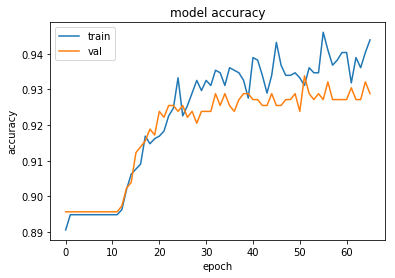

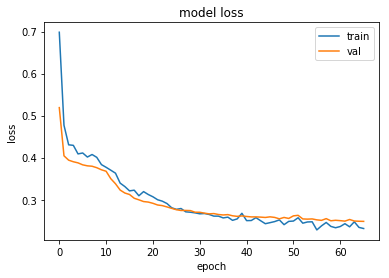

In [855]:
epochs = 150
batch_size = 8

model = buildManyToOneModel(X_train_norm.shape)
callback = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
history = model.fit(X_train_norm, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_norm, Y_val), callbacks=[callback], verbose=0)

Y_pred = model.predict_classes(X_test_norm)
confusion_matrix(Y_test, Y_pred)
print(classification_report(y_true=Y_test, y_pred=Y_pred))

lbt.plotmodelrecords(history=history, val_set=True)


##### training - over-sampling

Model: "sequential_203"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_367 (LSTM)              (None, 6, 9)              432       
_________________________________________________________________
dropout_353 (Dropout)        (None, 6, 9)              0         
_________________________________________________________________
lstm_368 (LSTM)              (None, 6, 5)              300       
_________________________________________________________________
dropout_354 (Dropout)        (None, 6, 5)              0         
_________________________________________________________________
lstm_369 (LSTM)              (None, 5)                 220       
_________________________________________________________________
dropout_355 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_190 (Dense)            (None, 1)              

array([[1344,  106],
       [  42,  232]], dtype=int64)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1450
           1       0.69      0.85      0.76       274

    accuracy                           0.91      1724
   macro avg       0.83      0.89      0.85      1724
weighted avg       0.92      0.91      0.92      1724



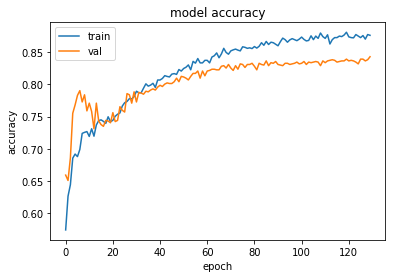

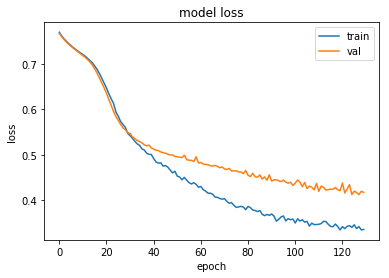

In [861]:
epochs = 400
batch_size = 256

model2 = buildManyToOneModel(X_train_norm_oversamp.shape)
callback = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
history2 = model2.fit(X_train_norm_oversamp, Y_train_oversamp, epochs=epochs, batch_size=batch_size, validation_data=(X_val_norm_oversamp, Y_val_oversamp), callbacks=[callback], verbose=0)

Y_pred2 = model2.predict_classes(X_test_norm)
confusion_matrix(Y_test, Y_pred2)
print(classification_report(y_true=Y_test, y_pred=Y_pred2))

lbt.plotmodelrecords(history=history2, val_set=True)


#### Ensemble

In [865]:
Y_pred = model.predict_proba(X_test_norm)
Y_pred2 = model2.predict_proba(X_test_norm)
# Y_pred = model.predict_classes(X_test_norm)
# Y_pred2 = model2.predict_classes(X_test_norm)
Y_pred_avg = [1 if val >= 0.4 else 0 for val in (Y_pred + Y_pred2) / 2]
confusion_matrix(Y_test, Y_pred_avg)
print(classification_report(y_true=Y_test, y_pred=Y_pred_avg))


array([[1404,   46],
       [  63,  211]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1450
           1       0.82      0.77      0.79       274

    accuracy                           0.94      1724
   macro avg       0.89      0.87      0.88      1724
weighted avg       0.94      0.94      0.94      1724



### Feature Importance for LSTM model
- can't use SHAP for 3d array data

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1408/1408 [00:25<00:00, 55.75it/s]


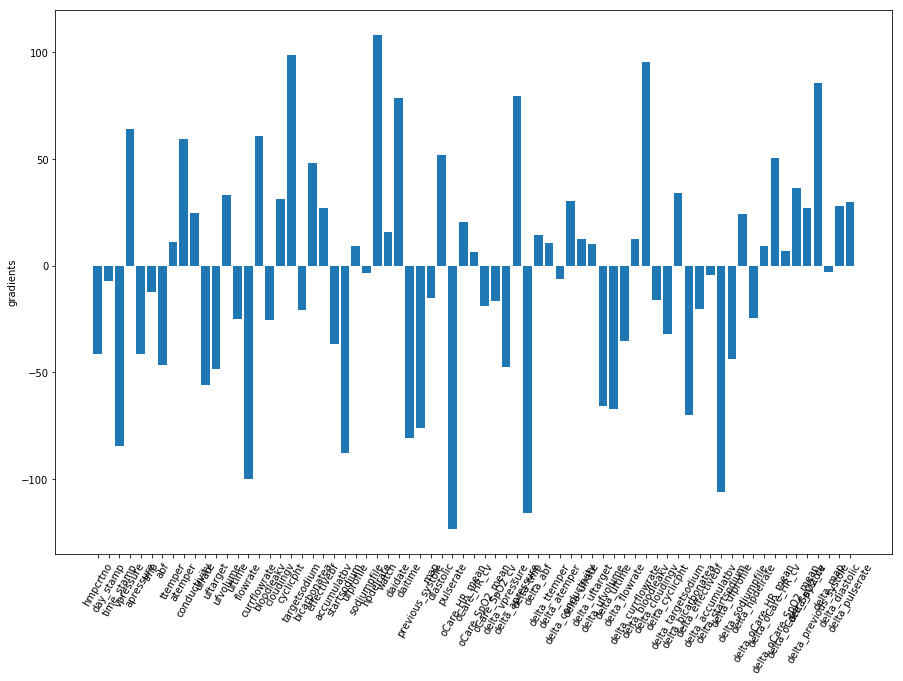

In [891]:
from scipy.ndimage import zoom

def gradient_importance(seq, model):
    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)
    with tf.GradientTape() as tape:
        predictions = model(seq)
    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads


def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('lstm_72').output, 
                        model.output])
    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)
    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]
    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=1)
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]
    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap


for sample_id in tqdm(range(X_train_norm.shape[0])):
    if sample_id == 0:
        grad_imp = gradient_importance(X_train_norm[sample_id], model2)
#         activation_ = activation_grad(X_train_norm[sample_id], model)
    else:
        grad_imp += gradient_importance(X_train_norm[sample_id], model2)
#         activation_ += activation_grad(X_train_norm[sample_id], model)


grad_imp = grad_imp / X_train_norm.shape[0]
# activation_ = activation_ / X_train_norm.shape[0]

plt.figure(figsize=(15,10))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(feature_cols)), feature_cols, rotation=60)
plt.ylabel('gradients')#; plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False);


# plt.figure(figsize=(12,8))
# plt.plot(X_train_norm[0])
# plt.ylabel('std series'); plt.xlabel('time lags')#; plt.title(pd.to_datetime(test_date[sequence_length+id_]))
# plt.twinx()
# plt.imshow(np.vstack([activation_]*30), alpha=0.35)
# plt.axis('off'); plt.colorbar()
# np.set_printoptions(False);



In [818]:
df_grad = pd.DataFrame({
    'feature_cols': feature_cols,
    'grad_imp': grad_imp
})
df_grad = df_grad.sort_values('grad_imp',ascending=False)
df_grad.head(10)
df_grad.tail(10)

top5_features = df_grad.feature_cols.values[:5]
opps_top5_features = df_grad.feature_cols.values[-5:]


,feature_cols,grad_imp
0,previous_systole,0.073093
1,delta_systole,0.020912
4,delta_oCare_HR_cv,-0.003469
3,oCare_SpO2_mean,-0.020082
2,map,-0.079051


,feature_cols,grad_imp
0,previous_systole,0.073093
1,delta_systole,0.020912
4,delta_oCare_HR_cv,-0.003469
3,oCare_SpO2_mean,-0.020082
2,map,-0.079051


##### training - down-sampling (不佳)

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_115 (LSTM)              (None, 6, 153)            117504    
_________________________________________________________________
dropout_109 (Dropout)        (None, 6, 153)            0         
_________________________________________________________________
lstm_116 (LSTM)              (None, 76)                69920     
_________________________________________________________________
dropout_110 (Dropout)        (None, 76)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 77        
Total params: 187,501
Trainable params: 187,501
Non-trainable params: 0
_________________________________________________________________


array([[   0, 1450],
       [   0,  274]], dtype=int64)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1450
           1       0.16      1.00      0.27       274

    accuracy                           0.16      1724
   macro avg       0.08      0.50      0.14      1724
weighted avg       0.03      0.16      0.04      1724



C:\ProgramData\Anaconda3\envs\tensorflow_gpu_v2\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


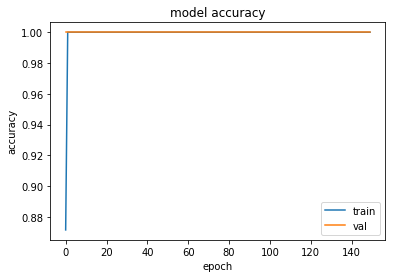

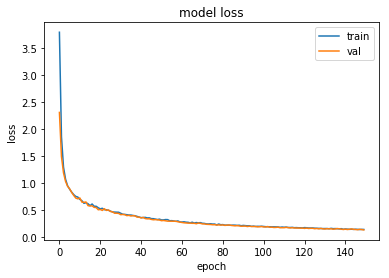

In [165]:
epochs = 150
batch_size = 8

model = buildManyToOneModel(X_train_norm_samp.shape)
callback = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
history = model.fit(X_train_norm_samp, Y_train_samp, epochs=epochs, batch_size=batch_size, validation_data=(X_val_norm_samp, Y_val_samp), callbacks=[callback], verbose=0)

Y_pred = model.predict_classes(X_test_norm)
confusion_matrix(Y_test, Y_pred)
print(classification_report(y_true=Y_test, y_pred=Y_pred))

lbt.plotmodelrecords(history=history, val_set=True)


##### tune hyperparameters

In [ ]:
node_nums = list(range(1,100,5))
performance_collect = {}
performance_collect['precision'] = []
performance_collect['recall'] = []


for tid in range(len(node_nums)):
    model = buildManyToOneModel(X_train_norm.shape, node_nums[tid])
    callback = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
    history = model.fit(X_train_norm, Y_train, epochs=100, batch_size=8, validation_data=(X_val_norm, Y_val), callbacks=[callback], verbose=0)

    Y_pred = model.predict_classes(X_test_norm)
    confusion_matrix(Y_test, Y_pred)
    print(classification_report(y_true=Y_test, y_pred=Y_pred))

    performance_collect['precision'].append(precision_score(y_true=Y_test, y_pred=Y_pred))
    performance_collect['recall'].append(recall_score(y_true=Y_test, y_pred=Y_pred))



4
1


<Figure size 720x576 with 0 Axes>

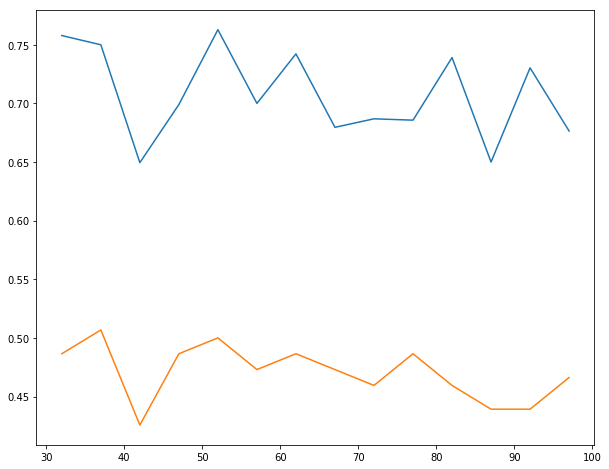

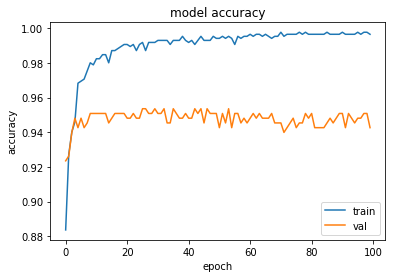

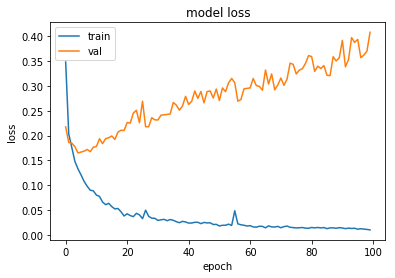

In [214]:
print(np.argmax(performance_collect['precision']))
print(np.argmax(performance_collect['recall']))
# print('best node_num: ', node_nums[12])

plt.figure(figsize=(10,8))
plt.plot(node_nums, performance_collect['precision'])
plt.plot(node_nums, performance_collect['recall'])
plt.show();

lbt.plotmodelrecords(history=history, val_set=True)


##### fine-tuned

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 6, 13)             2392      
_________________________________________________________________
dropout_24 (Dropout)         (None, 6, 13)             0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 6, 13)             1404      
_________________________________________________________________
dropout_25 (Dropout)         (None, 6, 13)             0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 13)                1404      
_________________________________________________________________
dropout_26 (Dropout)         (None, 13)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)               

array([[900,  20],
       [ 86,  62]], dtype=int64)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       920
           1       0.76      0.42      0.54       148

    accuracy                           0.90      1068
   macro avg       0.83      0.70      0.74      1068
weighted avg       0.89      0.90      0.89      1068



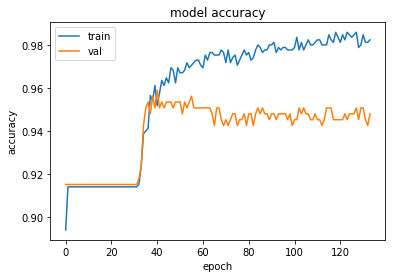

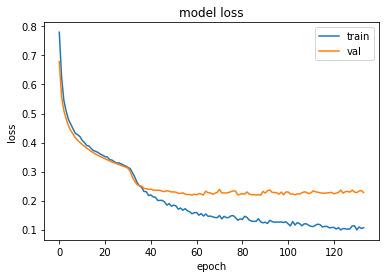

In [19]:
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(13, return_sequences=True, input_length=shape[1], input_dim=shape[2])) #
#     model.add(LSTM(13, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, input_length=shape[1], input_dim=shape[2]))
    model.add(Dropout(0.3))
#     model.add(LSTM(13, return_sequences=True, activity_regularizer=l1(0.1)))
#     model.add(LSTM(13, return_sequences=True, activity_regularizer=l2(0.1)))
    model.add(LSTM(13, return_sequences=True, activity_regularizer=l1_l2(0.01)))
    model.add(Dropout(0.3))
    model.add(LSTM(13, activity_regularizer=l1_l2(0.1)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model


model = buildManyToOneModel(X_train_norm.shape)
callback = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
history = model.fit(X_train_norm, Y_train, epochs=150, batch_size=8, validation_data=(X_val_norm, Y_val), callbacks=[callback], verbose=0)

Y_pred = model.predict_classes(X_test_norm)
confusion_matrix(Y_test, Y_pred)
print(classification_report(y_true=Y_test, y_pred=Y_pred))

lbt.plotmodelrecords(history=history, val_set=True)



##### save model
- delta_6: `delta_systole`, `delta_map`, `delta_diastolic`, `delta_pulserate`, `delta_oCare_HR_mean`, `delta_oCare_SpO2_mean`


In [40]:
path_savedmodel = 'saved-model/'
name_savedmodel = 'LSTM&format=V&target=Hypo_delta_20&feature=delta_selected.h5'
model.save(path_savedmodel+name_savedmodel)

model = load_model(path_savedmodel+name_savedmodel)
model.summary()


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 6, 13)             1508      
_________________________________________________________________
dropout_40 (Dropout)         (None, 6, 13)             0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 6, 13)             1404      
_________________________________________________________________
dropout_41 (Dropout)         (None, 6, 13)             0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 13)                1404      
_________________________________________________________________
dropout_42 (Dropout)         (None, 13)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)               

### Feature Forward Selection

In [ ]:
def buildManyToOneModel(shape, node_num, regularize_amount, dropout_amount): 
    model = Sequential()
    model.add(LSTM(node_num, input_lengSth=shape[1], input_dim=shape[2], activity_regularizer=l1_l2(regularize_amount))) #return_sequences=True, 
#     model.add(LSTM(13, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, input_length=shape[1], input_dim=shape[2]))
    model.add(Dropout(0.3))
#     model.add(LSTM(16, return_sequences=True, activity_regularizer=l1_l2(0.01)))
#     model.add(Dropout(0.2))
#     model.add(LSTM(16, activity_regularizer=l1_l2(0.01)))
#     model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    model.summary()
    return model


In [22]:
df_agg.columns[4:40]


Index(['vpressure', 'apressure', 'tmp', 'abf', 'ttemper', 'atemper',
       'conductivity', 'ufrate', 'uftarget', 'ufvolume', 'uftime', 'flowrate',
       'currflowrate', 'bloodleakv', 'cloudingv', 'cyclicpht', 'targetsodium',
       'bicarbonatea', 'effectivebf', 'accumulatbv', 'startsodium',
       'ufprofile', 'sodiumpfile', 'hpdelrate', 'watch', 'daidate', 'daitime',
       'map', 'diastolic', 'pulserate', 'Hypo_delta_20', 'Hypo_90mmHg',
       'oCare_HR_mean', 'oCare_HR_cv', 'oCare_SpO2_mean', 'oCare_SpO2_cv'],
      dtype='object')

19

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'vpressure']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21917.98it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 2)              40        
_________________________________________________________________
dropout (Dropout)            (None, 6, 2)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 16)             1216      
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 16)             0         
________________________________

array([[832,  88],
       [ 33, 115]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       920
           1       0.57      0.78      0.66       148

    accuracy                           0.89      1068
   macro avg       0.76      0.84      0.79      1068
weighted avg       0.91      0.89      0.89      1068



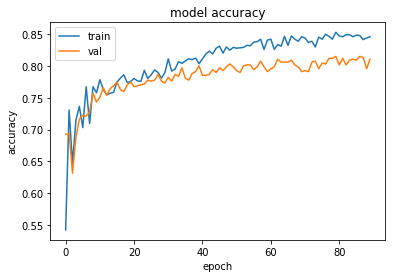

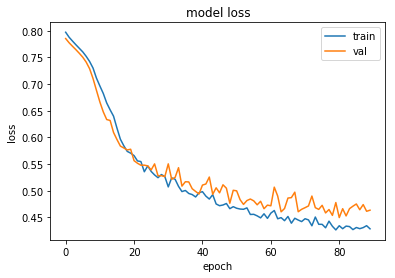

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'apressure']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21949.26it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 6, 2)              40        
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 2)              0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 6, 16)             1216      
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 16)             0         
______________________________

array([[880,  40],
       [ 32, 116]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       920
           1       0.74      0.78      0.76       148

    accuracy                           0.93      1068
   macro avg       0.85      0.87      0.86      1068
weighted avg       0.93      0.93      0.93      1068



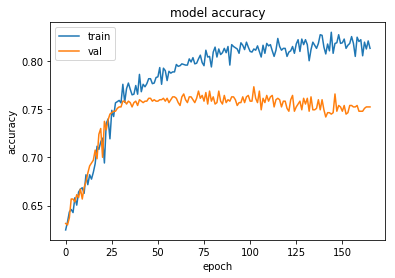

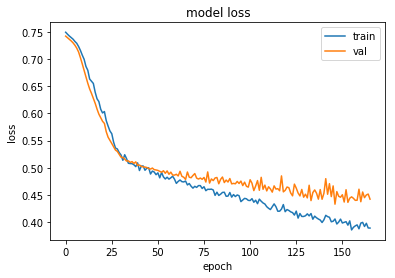

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'tmp']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21928.40it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 6, 2)              40        
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 2)              0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 6, 16)             1216      
_________________________________________________________________
dropout_7 (Dropout)          (None, 6, 16)             0         
______________________________

array([[820, 100],
       [ 31, 117]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.89      0.93       920
           1       0.54      0.79      0.64       148

    accuracy                           0.88      1068
   macro avg       0.75      0.84      0.78      1068
weighted avg       0.90      0.88      0.89      1068



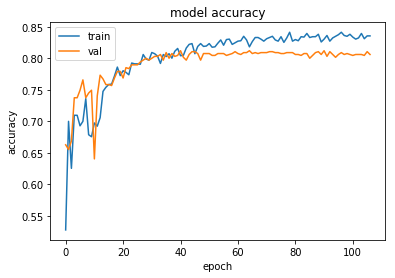

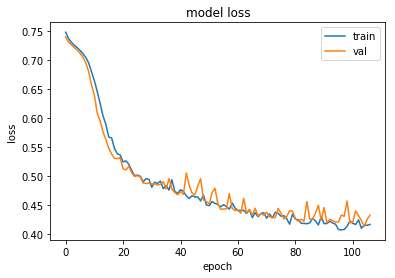

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'abf']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<?, ?it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 6, 2)              40        
_________________________________________________________________
dropout_9 (Dropout)          (None, 6, 2)              0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_10 (Dropout)         (None, 6, 16)             0         
______________________________

array([[830,  90],
       [ 31, 117]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       920
           1       0.57      0.79      0.66       148

    accuracy                           0.89      1068
   macro avg       0.76      0.85      0.80      1068
weighted avg       0.91      0.89      0.89      1068



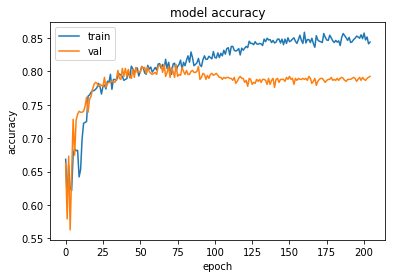

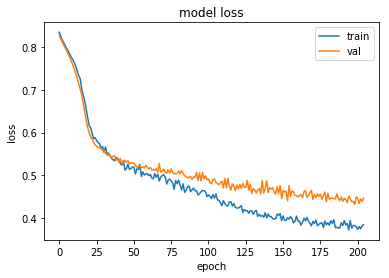

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'ttemper']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<?, ?it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_12 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_13 (Dropout)         (None, 6, 16)             0         
______________________________

array([[822,  98],
       [ 30, 118]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.89      0.93       920
           1       0.55      0.80      0.65       148

    accuracy                           0.88      1068
   macro avg       0.76      0.85      0.79      1068
weighted avg       0.91      0.88      0.89      1068



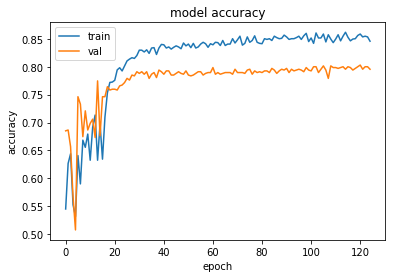

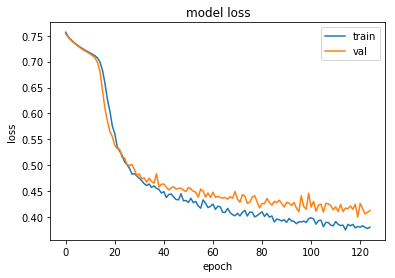

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'atemper']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23184.59it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_15 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_16 (Dropout)         (None, 6, 16)             0         
______________________________

array([[782, 138],
       [ 29, 119]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       920
           1       0.46      0.80      0.59       148

    accuracy                           0.84      1068
   macro avg       0.71      0.83      0.75      1068
weighted avg       0.89      0.84      0.86      1068



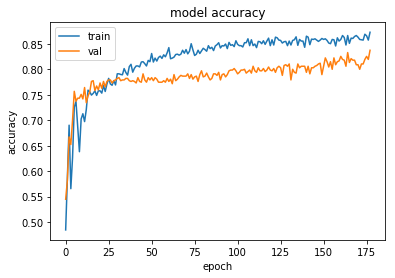

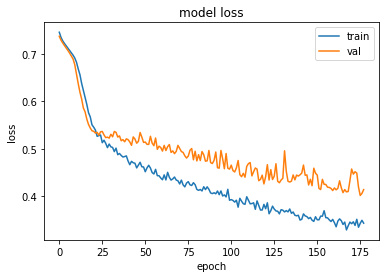

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'conductivity']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21949.26it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_18 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_19 (Dropout)         (None, 6, 16)             0         
______________________________

array([[825,  95],
       [ 30, 118]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       920
           1       0.55      0.80      0.65       148

    accuracy                           0.88      1068
   macro avg       0.76      0.85      0.79      1068
weighted avg       0.91      0.88      0.89      1068



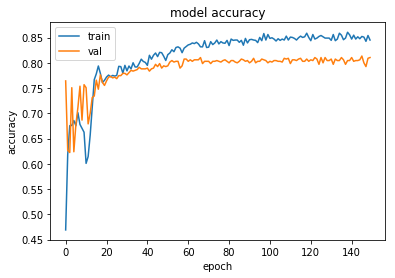

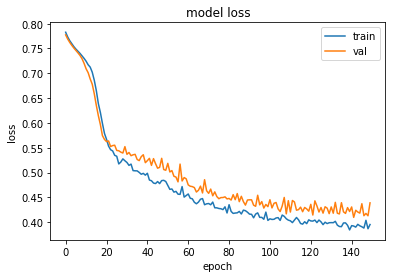

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'ufrate']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21970.16it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_21 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_22 (Dropout)         (None, 6, 16)             0         
______________________________

array([[794, 126],
       [ 30, 118]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       920
           1       0.48      0.80      0.60       148

    accuracy                           0.85      1068
   macro avg       0.72      0.83      0.76      1068
weighted avg       0.90      0.85      0.87      1068



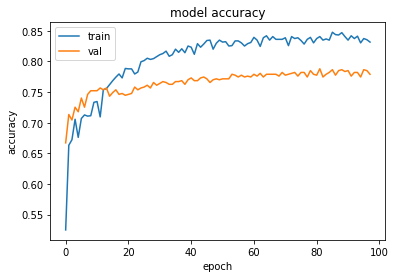

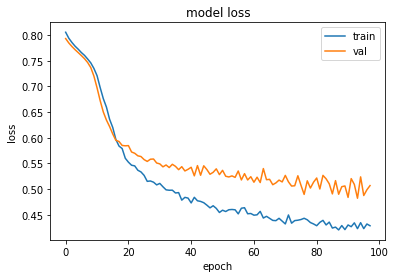

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'uftarget']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20961.99it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_24 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_25 (Dropout)         (None, 6, 16)             0         
______________________________

array([[801, 119],
       [ 30, 118]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       920
           1       0.50      0.80      0.61       148

    accuracy                           0.86      1068
   macro avg       0.73      0.83      0.76      1068
weighted avg       0.90      0.86      0.87      1068



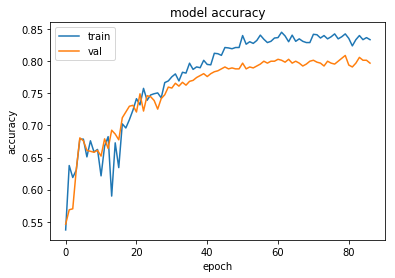

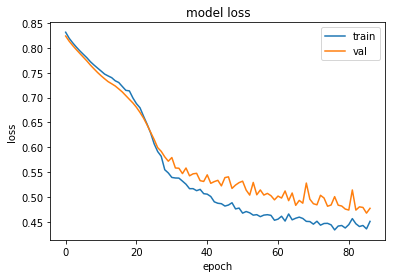

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'ufvolume']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21938.82it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_27 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_28 (Dropout)         (None, 6, 16)             0         
______________________________

array([[764, 156],
       [ 32, 116]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       920
           1       0.43      0.78      0.55       148

    accuracy                           0.82      1068
   macro avg       0.69      0.81      0.72      1068
weighted avg       0.89      0.82      0.84      1068



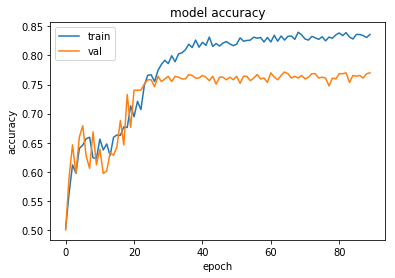

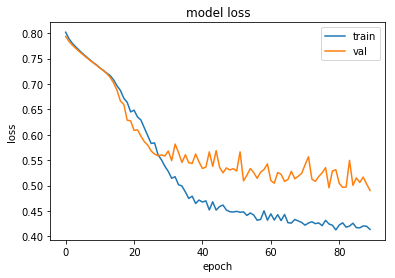

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'uftime']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21907.57it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_30 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_31 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[819, 101],
       [ 29, 119]], dtype=int64)

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       920
           1       0.54      0.80      0.65       148

    accuracy                           0.88      1068
   macro avg       0.75      0.85      0.79      1068
weighted avg       0.91      0.88      0.89      1068



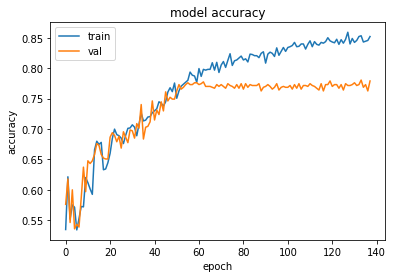

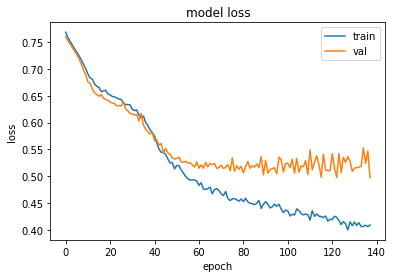

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'flowrate']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21938.82it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_33 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_34 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[829,  91],
       [ 30, 118]], dtype=int64)

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       920
           1       0.56      0.80      0.66       148

    accuracy                           0.89      1068
   macro avg       0.76      0.85      0.80      1068
weighted avg       0.91      0.89      0.89      1068



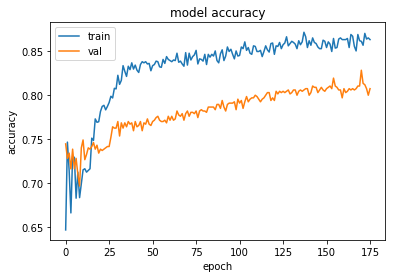

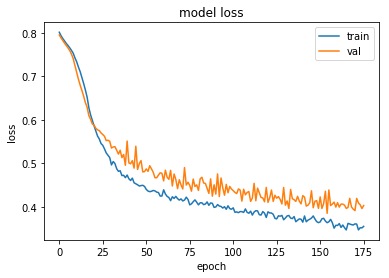

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'currflowrate']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 22043.64it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_36 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_37 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[826,  94],
       [ 31, 117]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       920
           1       0.55      0.79      0.65       148

    accuracy                           0.88      1068
   macro avg       0.76      0.84      0.79      1068
weighted avg       0.91      0.88      0.89      1068



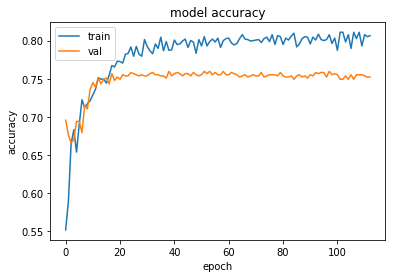

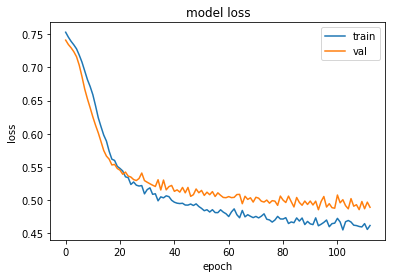

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'bloodleakv']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23034.12it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_39 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_40 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[818, 102],
       [ 30, 118]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.89      0.93       920
           1       0.54      0.80      0.64       148

    accuracy                           0.88      1068
   macro avg       0.75      0.84      0.78      1068
weighted avg       0.91      0.88      0.89      1068



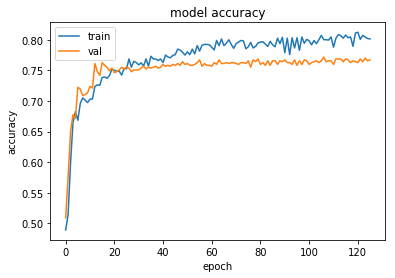

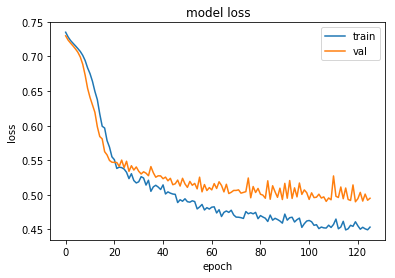

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'cloudingv']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<?, ?it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_42 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_43 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[806, 114],
       [ 30, 118]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       920
           1       0.51      0.80      0.62       148

    accuracy                           0.87      1068
   macro avg       0.74      0.84      0.77      1068
weighted avg       0.90      0.87      0.88      1068



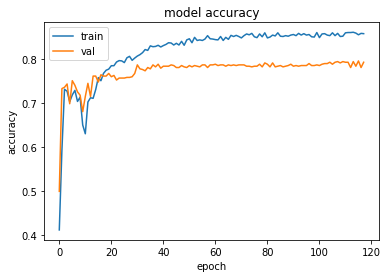

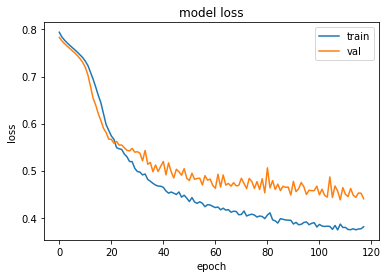

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'cyclicpht']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<?, ?it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_45 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_46 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[853,  67],
       [ 32, 116]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       920
           1       0.63      0.78      0.70       148

    accuracy                           0.91      1068
   macro avg       0.80      0.86      0.82      1068
weighted avg       0.92      0.91      0.91      1068



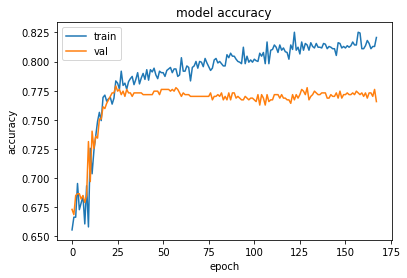

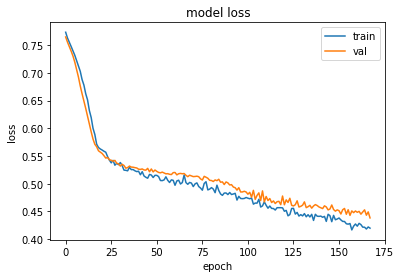

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'targetsodium']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23149.70it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_48 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_49 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[809, 111],
       [ 29, 119]], dtype=int64)

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       920
           1       0.52      0.80      0.63       148

    accuracy                           0.87      1068
   macro avg       0.74      0.84      0.77      1068
weighted avg       0.90      0.87      0.88      1068



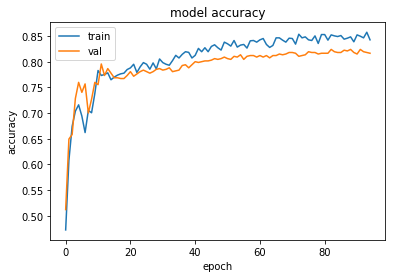

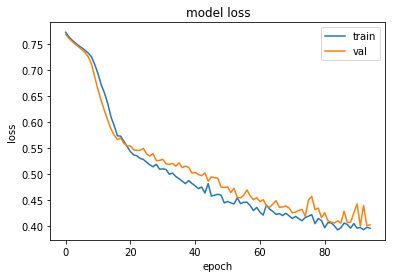

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'bicarbonatea']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21938.82it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_51 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_52 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[827,  93],
       [ 32, 116]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       920
           1       0.56      0.78      0.65       148

    accuracy                           0.88      1068
   macro avg       0.76      0.84      0.79      1068
weighted avg       0.91      0.88      0.89      1068



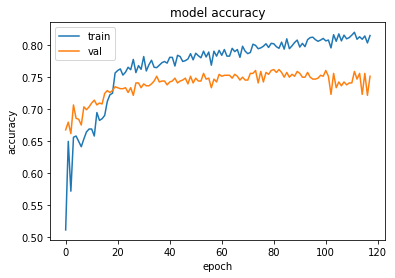

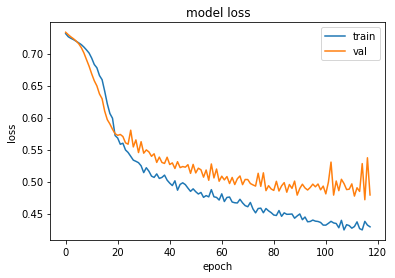

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'effectivebf']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<?, ?it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_54 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_55 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[804, 116],
       [ 30, 118]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.87      0.92       920
           1       0.50      0.80      0.62       148

    accuracy                           0.86      1068
   macro avg       0.73      0.84      0.77      1068
weighted avg       0.90      0.86      0.88      1068



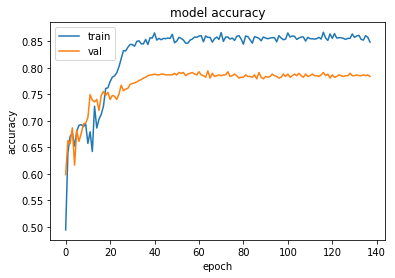

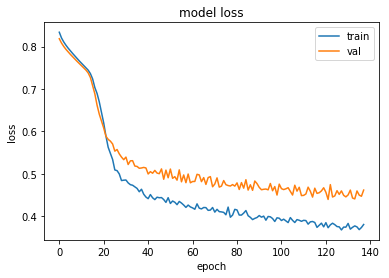

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'accumulatbv']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<?, ?it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_57 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_58 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[837,  83],
       [ 31, 117]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       920
           1       0.58      0.79      0.67       148

    accuracy                           0.89      1068
   macro avg       0.77      0.85      0.80      1068
weighted avg       0.91      0.89      0.90      1068



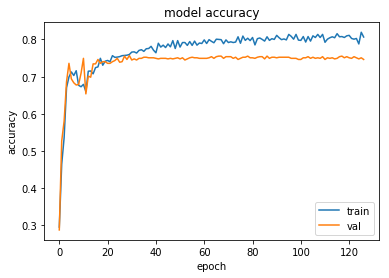

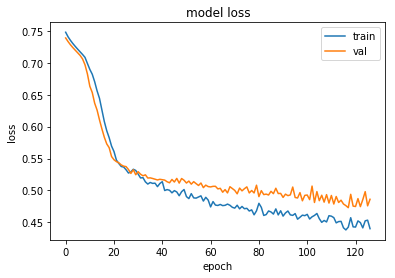

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'startsodium']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20801.33it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_60 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_61 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_61 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[822,  98],
       [ 31, 117]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.89      0.93       920
           1       0.54      0.79      0.64       148

    accuracy                           0.88      1068
   macro avg       0.75      0.84      0.79      1068
weighted avg       0.91      0.88      0.89      1068



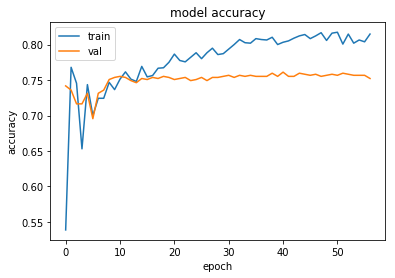

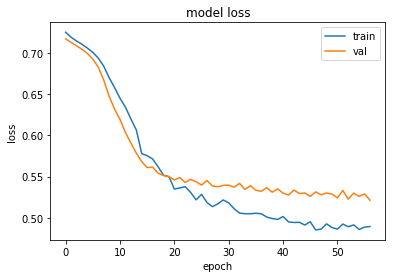

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'ufprofile']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21949.26it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_63 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_64 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[810, 110],
       [ 31, 117]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       920
           1       0.52      0.79      0.62       148

    accuracy                           0.87      1068
   macro avg       0.74      0.84      0.77      1068
weighted avg       0.90      0.87      0.88      1068



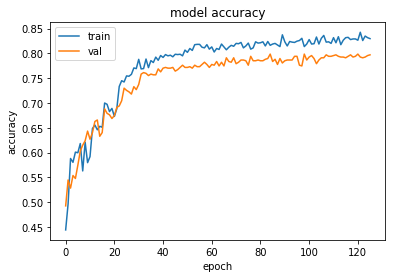

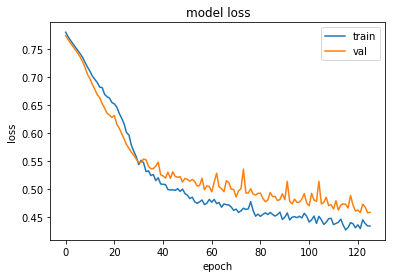

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'sodiumpfile']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<?, ?it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_66 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_67 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[830,  90],
       [ 32, 116]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       920
           1       0.56      0.78      0.66       148

    accuracy                           0.89      1068
   macro avg       0.76      0.84      0.79      1068
weighted avg       0.91      0.89      0.89      1068



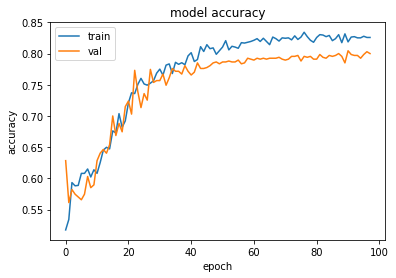

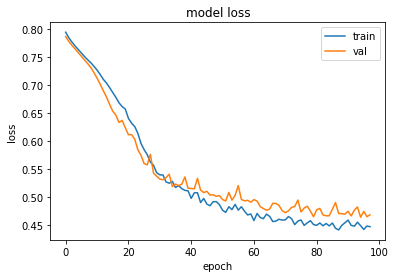

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'hpdelrate']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21938.82it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_69 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_69 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_70 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_70 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[859,  61],
       [ 38, 110]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       920
           1       0.64      0.74      0.69       148

    accuracy                           0.91      1068
   macro avg       0.80      0.84      0.82      1068
weighted avg       0.91      0.91      0.91      1068



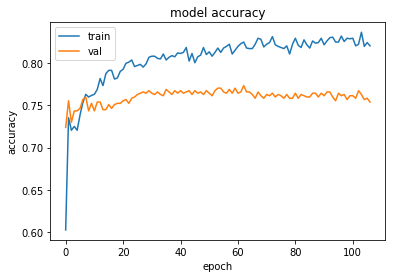

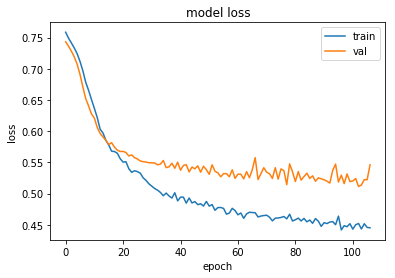

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'watch']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21928.40it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_72 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_73 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_73 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[838,  82],
       [ 32, 116]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       920
           1       0.59      0.78      0.67       148

    accuracy                           0.89      1068
   macro avg       0.77      0.85      0.80      1068
weighted avg       0.91      0.89      0.90      1068



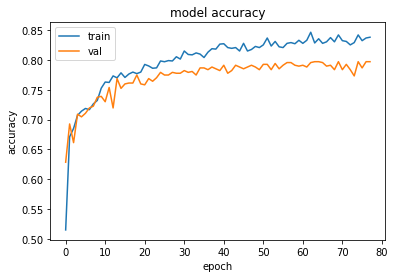

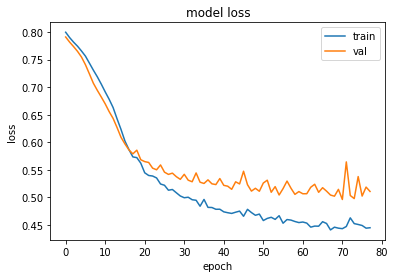

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'daidate']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<?, ?it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_75 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_76 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_76 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[794, 126],
       [ 32, 116]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       920
           1       0.48      0.78      0.59       148

    accuracy                           0.85      1068
   macro avg       0.72      0.82      0.75      1068
weighted avg       0.89      0.85      0.87      1068



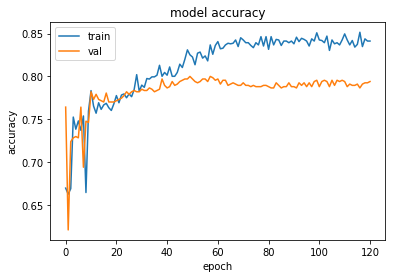

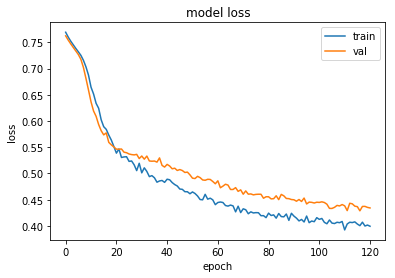

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'daitime']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23242.99it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_78 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_79 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_79 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[772, 148],
       [ 31, 117]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       920
           1       0.44      0.79      0.57       148

    accuracy                           0.83      1068
   macro avg       0.70      0.81      0.73      1068
weighted avg       0.89      0.83      0.85      1068



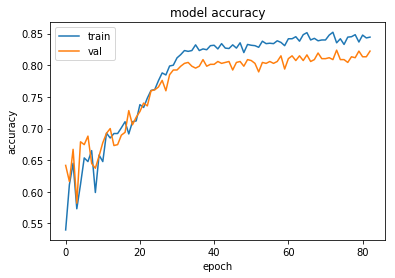

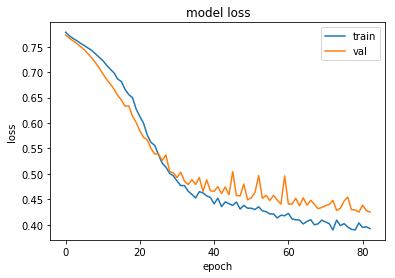

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'map']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21928.40it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_81 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_82 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_82 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[799, 121],
       [ 30, 118]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       920
           1       0.49      0.80      0.61       148

    accuracy                           0.86      1068
   macro avg       0.73      0.83      0.76      1068
weighted avg       0.90      0.86      0.87      1068



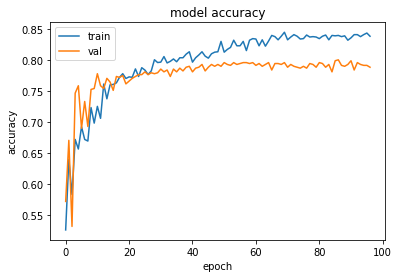

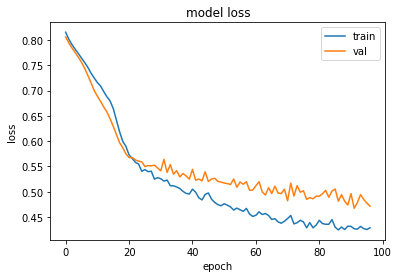

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'diastolic']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 21949.26it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_84 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_85 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_85 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[816, 104],
       [ 30, 118]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       920
           1       0.53      0.80      0.64       148

    accuracy                           0.87      1068
   macro avg       0.75      0.84      0.78      1068
weighted avg       0.90      0.87      0.88      1068



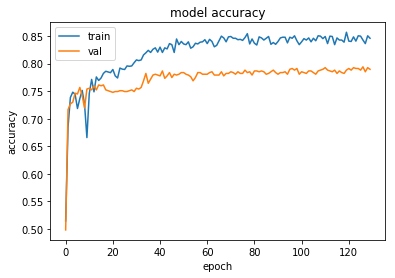

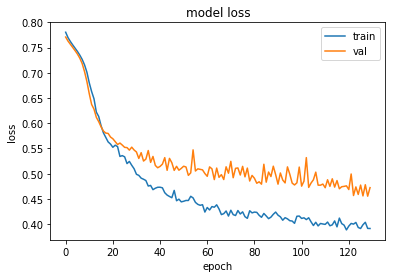

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'pulserate']


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23011.14it/s]


(77, 7, 2)
Original Y=0:  1113
Original Y=1:  104
num of Y label = 0 : 778
num of Y label = 1 : 73
num of Y label = 0 : 335
num of Y label = 1 : 31
train_norm - Under-sampling:  (73, 6, 2) (73,)
val_norm - Under-sampling:  (31, 6, 2) (31,)
train_norm - Over-sampling:  (1556, 6, 2) (1556,)
val_norm - Over-sampling:  (670, 6, 2) (670,)
Testset Y=1:  148
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_87 (LSTM)               (None, 6, 2)              40        
_________________________________________________________________
dropout_87 (Dropout)         (None, 6, 2)              0         
_________________________________________________________________
lstm_88 (LSTM)               (None, 6, 16)             1216      
_________________________________________________________________
dropout_88 (Dropout)         (None, 6, 16)             0         
_____________________________

array([[848,  72],
       [ 32, 116]], dtype=int64)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       920
           1       0.62      0.78      0.69       148

    accuracy                           0.90      1068
   macro avg       0.79      0.85      0.82      1068
weighted avg       0.92      0.90      0.91      1068



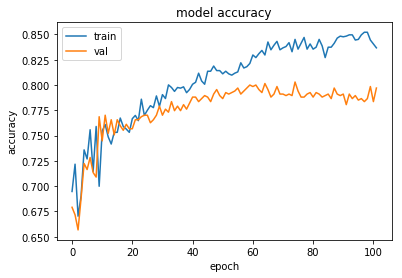

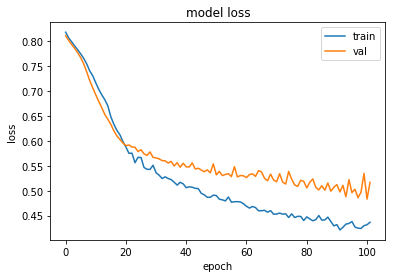

  0%|                                                                                                                                                                                                                | 0/23 [00:00<?, ?it/s]

['delta_systole', 'Hypo_delta_20']


KeyError: "['Hypo_delta_20'] not in index"

In [14]:
performance_collect = {}
performance_collect['precision'] = []
performance_collect['recall'] = []
node_num, regularize_amount, dropout_amount = None, None, None

for item in df_agg.columns[4:40]:
    
    if item not in ['delta_systole']:
    
        feature_list = ['delta_systole']#,'delta_diastolic','delta_flowrate', 'delta_abf']
        # 2nd choose: delta_diastolic
        # 3rd choose: delta_flowrate
        # 4th choose: delta_abf
        feature_list.append(item)
        print(feature_list)

        hmp_seq, hmp_seq_y, feature_cols = build_dataset(df_agg, window, feature_list, hmp_seq, hmp_seq_y)
        print(np.array(hmp_seq['10380']).shape)
        
        patientfortrain = list(hmp_seq.keys())[:12]
        patientfortest = list(hmp_seq.keys())[12:]
        X_train_, Y_train = [], []
        X_test_, Y_test = [], []
        X_train_norm, X_train_norm_samp, X_train_norm_oversamp, Y_train, Y_train_samp, Y_train_oversamp, \
        X_val_norm, X_val_norm_samp, X_val_norm_oversamp, Y_val, Y_val_samp, Y_val_oversamp, X_test_norm, Y_test = \
        format_data(patientfortrain, patientfortest, X_train_, Y_train, X_test_, Y_test)


# xticks = []
# for node_num in range(4, 150, 10):
#     for regularize_amount in [0.5, 0.1, 0.05, 0.01]:
#         for dropout_amount in [0.5, 0.3, 0.1, 0.05]:
            
#             xticks.append(f'{node_num}-{regularize_amount}-{dropout_amount}')
            
#             print(f' ====== input layer node_num: {node_num} - l1_l2({regularize_amount}) - dropout({dropout_amount}) ====== ')
            
        # use over-sampling
        model = buildManyToOneModel(X_train_norm_oversamp.shape, node_num, regularize_amount, dropout_amount)
        callback = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
        history = model.fit(X_train_norm_oversamp, Y_train_oversamp, epochs=300, batch_size=128, validation_data=(X_val_norm_oversamp, Y_val_oversamp), callbacks=[callback], verbose=0)

        Y_pred = model.predict_classes(X_test_norm)
        confusion_matrix(Y_test, Y_pred)
        print(classification_report(y_true=Y_test, y_pred=Y_pred))

        performance_collect['precision'].append(precision_score(y_true=Y_test, y_pred=Y_pred))
        performance_collect['recall'].append(recall_score(y_true=Y_test, y_pred=Y_pred))

        lbt.plotmodelrecords(history=history, val_set=True)

        

30
36
1
5


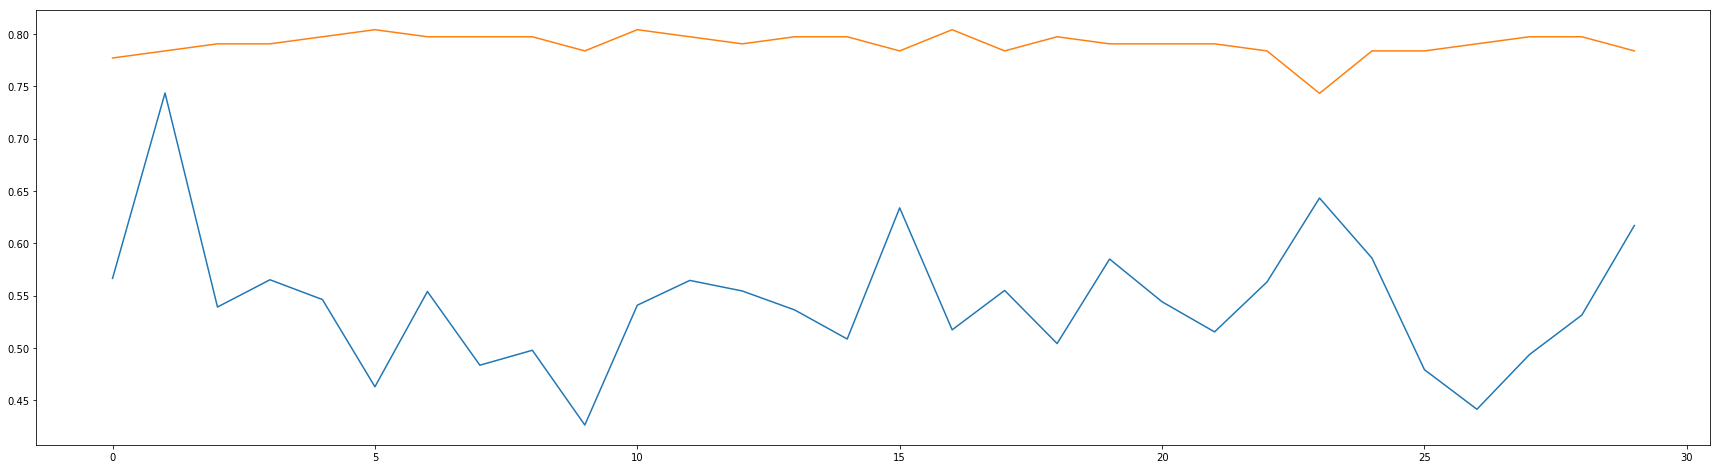

In [16]:
# node_nums = range(4, 30, 5)
xticks = df_agg.columns[4:40]
print(len(performance_collect['precision']))
print(len(xticks))
print(np.argmax(performance_collect['precision']))
print(np.argmax(performance_collect['recall']))
# print('best node_num: ', node_nums[12])
# print([performance_collect['precision'].index(x) for x in performance_collect['precision'] if x > 0.77])
# performance_collect['precision'][7]
# performance_collect['recall'][7]
# xticks[7]

plt.figure(figsize=(30,8))
plt.plot(performance_collect['precision'])
plt.plot(performance_collect['recall'])
# plt.xticks(xticks, rotation=45)
plt.show();


# lbt.plotmodelrecords(histsory=history, val_set=True)


##### Inspecting 

In [176]:
# input_index = [int(item[0][0]) for item in X_test_]
# index_predict_result = pd.DataFrame({
#     'input_index': input_index,
#     'Y_pred': [item[0] for item in Y_pred]
# })
# index_predict_result.shape
# index_predict_result.head()

# df_agg['input_index'] = df_agg.index
# df_agg = pd.merge(df_agg, index_predict_result, on='input_index', how='left')
# df_agg.shape
# df_agg.head()

# df_agg['Hypo_delta_20'] = df_agg['Hypo_delta_20'].apply(lambda x: int(float(x.split(',')[0])))
# df_agg.shape
# df_agg.head()

# df_agg_test = df_agg[~df_agg['Y_pred'].isnull()]
# Hypo_delta_20_list = []
# for hmpcrtno in df_agg_test.hmpcrtno.unique():
#     for item in hmp_seq_y[str(hmpcrtno.split('.')[0])]:
#         Hypo_delta_20_list.append(item)

# df_agg_test['Hypo_delta_20'] = Hypo_delta_20_list
df_agg_test.shape
# df_agg_test.head()

# df_agg_test[(df_agg_test['Hypo_delta_20'] == 1.0) & (df_agg_test['Y_pred'] == 1.0)][:10]
# df_agg_test[(df_agg_test['Hypo_delta_20'] == 1.0) & (df_agg_test['Y_pred'] == 0.0)][:10]
# df_agg_test[(df_agg_test['Hypo_delta_20'] == 0.0) & (df_agg_test['Y_pred'] == 1.0)][:10]
# df_agg_test[(df_agg_test['Hypo_delta_20'] == 0.0) & (df_agg_test['Y_pred'] == 0.0)][:10]
df_agg_test.hmpcrtno.unique()
df_agg_test[(df_agg_test['hmpcrtno'] == '45934.0')].iloc[:, np.r_[31,39,37,:31,33:37]][:50]

#&(df_agg_test['Hypo_delta_20'] == 0)


(1068, 40)

array(['258260.0', '32813.0', '3376.0', '44488.0', '45934.0', '56075.0',
       '57830.0', '63579.0', '7146.0', '90496.0', '96961.0'], dtype=object)

,Hypo_delta_20,Y_pred,delta_systole,hmpcrtno,day_stamp,systole,time_stamp,vpressure,apressure,tmp,abf,ttemper,atemper,conductivity,ufrate,uftarget,ufvolume,uftime,flowrate,currflowrate,bloodleakv,cloudingv,cyclicpht,targetsodium,bicarbonatea,effectivebf,accumulatbv,startsodium,ufprofile,sodiumpfile,hpdelrate,watch,daidate,daitime,oCare_HR_mean,oCare_HR_cv,oCare_SpO2_mean,oCare_SpO2_cv
1628,0,0.0,"-1.0,0.0,0.0",45934.0,0.0,114.0,"4.0,5.0,6.0","110.6,110.6,113.0","0.4,0.8,1.2","60.4,60.8,63.4","248.0,248.0,248.0","35.5,35.5,35.5","35.6,35.6,35.6","14.0,14.0,14.0","0.5,0.5,0.5","2.1,2.1,2.1","0.4,0.5,0.5800000000000001","194.0,183.0,173.0","500.0,500.0,500.0","485.8,487.2,490.0","49.2,49.0,49.0","48.0,48.0,48.0","750.0,750.0,600.0","1400.0,1400.0,1400.0","0.0,0.0,0.0","248.0,247.8,248.0","113.8,139.0,164.6","0.0,0.0,0.0","0.0,0.0,0.0","0.0,0.0,0.0","5.0,5.0,5.0","5.0,5.0,5.0","1090822.0,1090822.0,1090822.0","83607.0,84607.0,85607.0","74.76923076923076,104.96629213483143,84.139455...","0.032810244160839816,0.2448487427527649,0.1779...","98.09065934065936,82.91385767790263,93.3129251...","0.011054719321848346,0.027429445700977183,0.05..."
1629,0,0.0,0.0,45934.0,0.0,115.0,3.0,113.0,1.0,60.5,248.0,35.5,35.6,14.0,0.5,2.1,0.3,204.0,500.0,489.0,49.0,48.0,750.0,1400.0,0.0,248.0,89.0,0.0,0.0,0.0,5.0,5.0,1090822.0,82607.0,78.4655172413793,0.054925384790316535,98.40147783251233,0.008522821145228307
1630,0,0.0,"-1.0,0.0",45934.0,0.0,121.0,"10.0,12.0","112.4,114.5","0.8,0.0","61.4,62.5","248.0,248.0","35.5,35.5","35.6,35.6","14.0,14.0","0.5,0.5","2.1,2.1","0.94,1.1","132.0,111.75","500.0,500.0","492.2,490.75","49.0,49.0","48.0,48.0","600.0,562.5","1400.0,1400.0","0.0,0.0","248.0,248.0","265.0,316.5","0.0,0.0","0.0,0.0","0.0,0.0","5.0,5.0","5.0,5.0","1090822.0,1090822.0","93607.0,95607.0","77.77083333333333,77.56422018348623","0.12600522581453966,0.10557190859495008","94.33333333333331,95.78440366972477","0.0676473134949705,0.04082121653807312"
1631,0,0.0,"8.0,0.0,0.0",45934.0,0.0,122.0,"7.0,8.0,9.0","113.6,109.4,108.5","0.8,0.4,0.5","60.6,63.4,61.5","248.0,248.0,247.25","35.5,35.5,35.5","35.6,35.6,35.6","14.0,14.0,14.0","0.5,0.5,0.5","2.1,2.1,2.1","0.6799999999999999,0.76,0.85","162.6,152.0,142.25","500.0,500.0,500.0","492.2,484.4,492.0","49.0,49.0,49.0","48.0,48.0,48.0","750.0,750.0,750.0","1400.0,1400.0,1400.0","0.0,0.0,0.0","248.0,248.0,248.0","190.4,216.0,241.5","0.0,0.0,0.0","0.0,0.0,0.0","0.0,0.0,0.0","5.0,5.0,5.0","5.0,5.0,5.0","1090822.0,1090822.0,1090822.0","90607.0,91607.0,92607.0","74.54503464203233,72.56537102473499,92.1288343...","0.07092355865307333,0.06033910615702452,0.1256...","89.27944572748268,97.38869257950527,93.2668711...","0.09258523351721296,0.01531114695477523,0.0091..."
1632,0,0.0,"6.0,0.0,0.0",45934.0,0.0,127.0,"13.0,14.0,15.0","115.4,119.0,121.25","0.0,0.0,0.5","60.8,60.6,61.75","248.0,248.0,248.0","35.5,35.5,35.5","35.6,35.6,35.6","14.0,14.0,14.0","0.5,0.5,0.5","2.1,2.1,2.1","1.2,1.3,1.375","102.0,92.0,82.25","500.0,500.0,500.0","497.6,493.6,489.0","49.0,49.0,49.0","48.0,48.0,48.0","750.0,750.0,750.0","1400.0,1400.0,1400.0","0.0,0.0,0.0","247.8,248.0,248.0","339.8,365.0,390.5","0.0,0.0,0.0","0.0,0.0,0.0","0.0,0.0,0.0","5.0,5.0,5.0","5.0,5.0,5.0","1090822.0,1090822.0,1090822.0","100607.0,101607.0,102607.0","66.18677042801556,65.16617210682493,68.2838196...","0.05017239748496317,0.052885796949854964,0.081...","96.94163424124514,93.37685459940651,96.8726790...","0.02873420843007104,0.03487151315677135,0.0166..."
1633,0,0.0,"5.0,0.0,0.0",45934.0,0.0,132.0,"16.0,17.0,18.0","123.2,122.0,125.0","1.2,1.2,0.0","62.8,63.2,59.75","248.0,248.0,248.0","35.5,35.5,35.5","35.6,35.58,35.6","14.0,14.0,14.0","0.5,0.5,0.5","2.1,2.1,2.1","1.46,1.5399999999999998,1.65","72.0,62.0,51.75","500.0,500.0,500.0","484.4,491.2,489.0","49.0,49.0,49.0","48.0,48.0,48.0","750.0,600.0,750.0","1400.0,1400.0,1400.0","0.0,0.0,0.0","248.0,247.8,248.0","414.0,439.0,464.5","0.0,0.0,0.0","0.0,0.0,0.0","0.0,0.0,0.0","5.0,5.0,5.0","5.0,5.0,5.0","1090822.0,1

In [172]:
df_bp = lbt.readDataset(path_dataset + bp_data_file)
df_bp.shape
# df_bp.head()

df_bp[(df_bp['hmpcrtno']==44488)&((df_bp['daidate']==1090829)|(df_bp['daidate']==1090827))]


(5066, 11)

,hmpcrtno,btrim,daidate,daitime,systole,map,diastolic,pulserate,watch,Hypo_delta_20,Hypo_90mmHg
1798,44488,B04,1090827,125809,143,89,65.0,85,2,0,0
1799,44488,B04,1090827,132803,166,101,70.0,93,2,0,0
1800,44488,B04,1090827,133001,142,92,75.0,93,2,1,0
1801,44488,B04,1090827,140003,150,87,71.0,95,2,0,0
1802,44488,B04,1090827,143001,134,90,71.0,95,2,0,0
1803,44488,B04,1090827,150003,132,86,69.0,95,2,0,0
1804,44488,B04,1090827,153003,147,94,70.0,93,2,0,0
1805,44488,B04,1090827,160001,142,88,71.0,96,2,0,0
1806,44488,B04,1090827,163003,150,99,85.0,99,2,0,0
1807,44488,B04,1090829,132602,156,87,71.0,96,2,0,0


##### 比較常預測錯的序列出現在：
1. 當天測量次數較少 (hmpcrtno=258260.0, day_stamp=40.0)
2. 有低血壓但誤判為無＝> 更常出現在一天的開頭幾次或最後幾次
2. 無低血壓但誤判為有＝> 更常出現在一天的最後幾次
